In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import template_funciones as tf # El template con nuestras funciones (tiene que estar en la misma carpeta que el notebook)
from scipy.linalg import solve_triangular

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

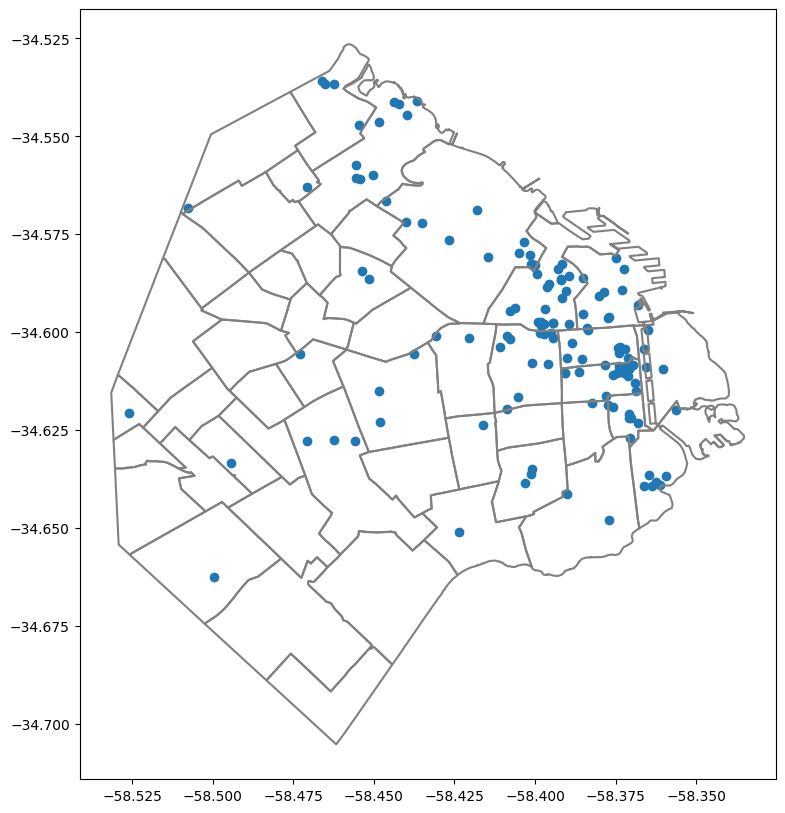

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

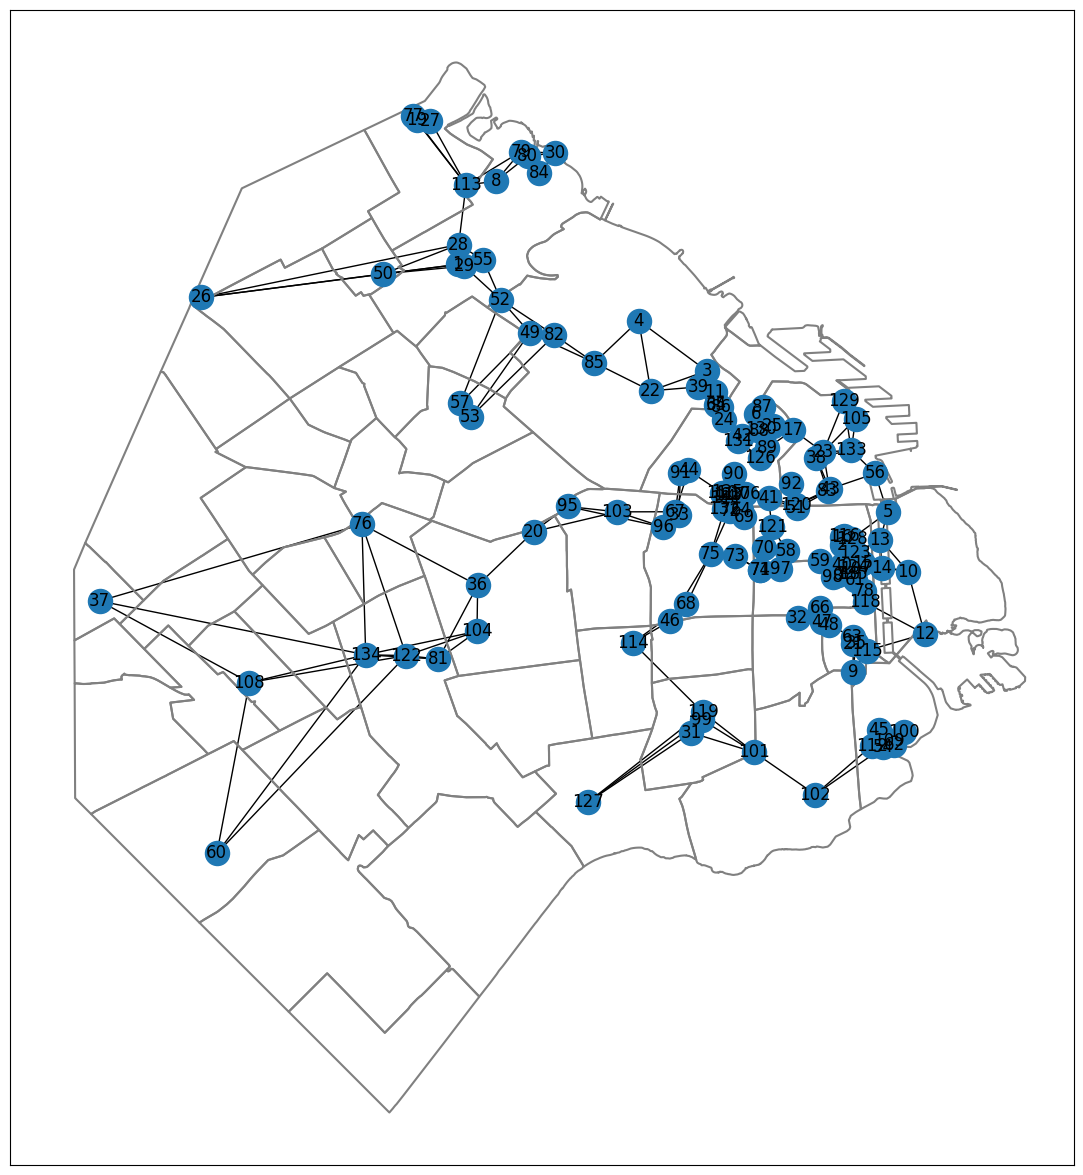

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## **Datos, fórmulas e interpretación de la introducción**  
<span style='color:green'>*(Debe haber errores, podemos ir corrigiendo a medida que vamos resolviendo...)*</span>

#### **MATRIZ DE ADYACENCIA $A$** *(o matriz de conectividad)* 

- $A \in \mathbb{R}^{n\times n},\quad n =$ cantidad de museos *(nodos)*
- $A_{ij} = $ relación entre el museo $i$ y el museo $j$
- $A_{ij} = 1$ si el museo $j$ **está entre los cercanos** al museo $i$, y vale $0$ si no lo está. Si $A_{ij} \in [0,1]$ se dice que esta **pesada** *(la que se utiliza para construir la matriz de transición entre museos es de este tipo)*. 
- En general, $A_{ij} \ne A_{ji}$, está **dirigida** *(no es simétrica)*.

#### **MATRIZ DE GRADO $K$**
- Es una matriz **diagonal** que contiene el número de aristas asociadas a cada vértice *(museo)*: la cantidad de conexiones de un museo, hacia cuántos otros apunta el grafo.
- $ K_{ij} = \begin{cases}   \displaystyle \sum_{h=1}^{n} A_{ih}, & \text{si } i = j \quad\text{(tiene en su diagonal la suma por filas de A)} \\ \\ 0, & \text{si } i \ne j \end{cases} $ 

#### **MATRIZ DE TRANSICIONES $C$**
- $C_{ji}$ almacena la **probabilidad de moverse desde el museo $i$ al museo $j$**.
- **Sus columnas suman 1** *(es estocástica)*.
-  Permite estudiar como es la circulación entre los museos.
- $C = A^T K^{-1}$
- Si $\vec{v}_0 \in \mathbb{R}^n$ guarda en su componente $i$ la **cantidad de visitantes** que acuden al museo $i$ al inicio de la jornada *(paso inicial $= 0$)*, entonces $\vec{v}_1 = C\vec{v}_0$.
- La **cantidad de visitantes en cada museo $i$ en el paso $k$** está en la componente $i$ del vector $\vec{v}_k = C\vec{v}_{k-1} \cdot (\ldots \cdot(C\vec{v}_0))) = C^k\vec{v}_0$

#### **PAGE RANK APLICADO A MUSEOS**
-  Representa la **probabilidad** de llegar a un museo específico después de recorrer los otros por un rato.


#### **VECTOR DE RANKINGS $\mathbf{\vec{p}}$**

- $\mathbf{\vec{p}} \in \mathbb{R}^n$
- $\mathbf{\vec{p}}_i$ contiene la **relevancia** de la página $i$ (o la **probabilidad**, en nuestro caso, de moverse desde el museo actual al museo $i$, dada por la **cercanía entre museos**).
- $\mathbf{\vec{p}}_i > 0 \;\forall \; i$
- $||\mathbf{\vec{p}}||_1 =\displaystyle \sum_{i=1}^{n}|\mathbf{\vec{p}}_i| = 1$  *(como tiene la distribución de probabilidades, sus componentes suman 1)*
- $\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1}\quad$ **(ECUACIÓN 3)**
  - $C$ es la matriz de transición.
  - $\vec{1}$ tiene $1$ en todas sus componentes
  - $\displaystyle ||\frac{1}{n}\vec{1}||_1 = 1$
  - $\alpha \in [0, 1]$ se denomina **factor de amortiguamiento**: representa la **probabilidad de un salto aleatorio** de una página a otra, **sin considerar el ranking de relevancia** de la página siguiente *(la cercanía entre un museo y otro)*. En nuestro caso implicaría el **fin de las visitas** a los distintos museos.
    - El **factor** $\displaystyle \frac{1}{n}$ *(el peso de cada página)* divide entre los $n$ museos la probabilidad $\alpha$ de que se interrumpan las visitas. 
    - En términos del museo, $\alpha>0$ sería  la probabilidad de que una serie de visitas se termine en un determinado momento.
    - Para $\alpha = 0$, la componente $\mathbf{\vec{p}}_j$, es decir: $\left(\begin{array}{c} \vdots \\ \mathbf{\vec{p}}_1 C_{j1} + \ldots + \mathbf{\vec{p}}_n C_{jn} \\ \vdots  \end{array}\right)$, se vuelve la suma del producto de cada entrada de la fila $j$ de la matriz $C$ por la componente correspondiente del vector $\mathbf{\vec{p}}$, entonces:
      - $\mathbf{\vec{p}}_j = \displaystyle \sum_{i = 1}^{n}C_{ji}\mathbf{\vec{p}}_i =$ la suma de los $\mathbf{\vec{p}}_i$ que le apuntan *(**relevancia** obtenida por la relevancia de las paǵinas que le apuntan)* **pesados** por la **probabilidad** de llegar a $j$ desde $i$: de efectivamente acceder a la página *(visitar el museo $j$ cuando se está en $i$)*.


#### **CONSIDERACIONES PARA LAS VISITAS A MUSEOS**

- La mayoría de los elementos de $C$ son distintos de cero *(no es rala)*: **todas las transiciones tienen algún nivel de plausibilidad**.
- **FUNCIÓN DE DISTANCIA**: $f(d_{ji}) = d_{ji}^{-1}$ recibe la distancia entre los museos $i$ y $j$ y devuelve su **inverso**, y se puede interpretar como: *qué tan atractivo (**relevante**) resulta ir a $j$ estando en $i$*. **Mientras más lejos, menos atractivo**.
- **MATRIZ DE ADYACENCIA $A$**: sus elementos son de la forma: $\displaystyle A_{ij} = \frac{1}{d_{ij}} \leadsto A = \left[\begin{array}{ccc}0 & \ldots &  \frac{1}{d_{1n}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{n1}} & \ldots &  0\end{array}\right] \leadsto A^T = \left[\begin{array}{ccc} 0 & \ldots &  \frac{1}{d_{n1}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{1n}} & \ldots &  0 \end{array}\right]$


- **ELEMENTOS DE LA MATRIZ DE TRANSICIÓN $C$**: sus elementos son de la forma: $\quad\displaystyle C_{ji} = \underbrace{P(i\to j)}_{\substack{\text{probabilidad}\\\text{de transición}\\\text{de $i$ a $j$}}} = \begin{cases} \frac{f(d_{ij})}{\displaystyle \sum_{\substack{k=1,\\ k\ne i}}^{n} f(d_{ik})}\quad \text{para $j\ne i$} \\ \\ 0 \quad \text{ para $j = i$ (no se puede ir del museo $i$ al $i$)}  \end{cases}$


#### **FORMA DE MATRICES Y VECTORES**

- $\displaystyle A_{ij} = f(d_{ij}) = \frac{1}{d_{ij}} \quad \leadsto \quad A = \left[\begin{array}{ccc} 0 & \ldots &  \frac{1}{d_{1n}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{n1}} & \ldots &  0\end{array}\right] = \left[\begin{array}{ccc} 0 & \ldots &  f(d_{1n}) \\ \vdots & \ddots & \vdots \\ f(d_{n1}) & \ldots &  0\end{array}\right] \quad \leadsto \quad A^T = \left[\begin{array}{ccc} 0 & \ldots &  \frac{1}{d_{n1}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{1n}} & \ldots &  0\end{array}\right] \quad \leadsto \quad A^T_{ij} = \begin{cases}f(d_{ji}) \quad i\ne j \\ \\ 0 \quad i=j \end{cases}$

- $\displaystyle C = A^T K^{-1} =  \left[\begin{array}{ccc}0 & \ldots &  \frac{1}{d_{n1}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{1n}} & \ldots & 0\end{array}\right] \left[\begin{array}{ccc}\displaystyle \frac{1}{\displaystyle\sum_{h=1}^{N} A_{ih}} & \ldots &  0 \\ \vdots & \ddots & \vdots \\ 0 & \ldots & \displaystyle  \frac{1}{\displaystyle\sum_{h=1}^{N} A_{nh}}\end{array}\right] = \left[\begin{array}{ccc}\displaystyle 0 & \ldots &  \displaystyle  \frac{1}{\displaystyle d_{n1} \cdot \sum_{h=1}^{N} A_{nh}} \\ \vdots & \ddots & \vdots \\ \displaystyle  \frac{1}{\displaystyle d_{1n} \cdot \sum_{h=1}^{N} A_{ih}} & \ldots & \displaystyle  0 \end{array}\right] \quad \leadsto \quad \quad\displaystyle C_{ij} = \begin{cases} \frac{f(d_{ji})}{\displaystyle \sum_{\substack{k=1,\\ k\ne j}}^{n} f(d_{jk})}\quad \text{para $j\ne i$} \\ \\ 0 \quad \text{ para $j = i$} \end{cases}$

- $\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1} \quad \land \quad ||\mathbf{\vec{p}}||_1 = 1 $

## **Aclaraciones sobre algunas funciones del template**

### `calcula_inversa_con_LU()`

Para **calcular la inversa de una matriz**, usamos lo visto en clase con respecto a **factorización LU**:

0. Si $A \in \mathbb{K}^{n\times n}$ es invertible, entonces $AA^{-1} = I = \left[\begin{array}{ccc} | & & | \\ \vec{e}_1 & \ldots & \vec{e}_n \\ | & & | \end{array}\right]$, donde $\vec{e}_j$ es el **vector canónico** que corresponde a la columna $j$ de $I$, con $1 \le j \le n$.

1. $ A = LU \implies A^{-1} = (LU)^{-1} = U^{-1}L^{-1} $

2. $A^{-1} = \left[\begin{array}{ccc} | & & | \\ \vec{x}_1 & \ldots & \vec{x}_n \\ | & & | \end{array}\right] \quad \substack{\implies \\ \text{por 0.} } \quad  A\left[\begin{array}{ccc} | & & | \\ \vec{x}_1 & \ldots & \vec{x}_n \\ | & & | \end{array}\right] = \left[\begin{array}{ccc} | & & | \\ \vec{e}_1 & \ldots & \vec{e}_n \\ | & & | \end{array}\right] \quad \implies \quad A\vec{x}_j = \vec{e}_j \quad \substack{\implies \\ \text{por 1.}} \quad LU\vec{x}_j = \vec{e}_j\;$ con $1 \le j \le n$.

3. $L\underbrace{U\vec{x}_j}_{\vec{y}_j} = \vec{e}_j \quad \leadsto \quad L\vec{y}_j = \vec{e}_j \quad$ Éste $\vec{y}_j$ lo calculamos con **sustitución hacia adelante** usando: `y_j = solve_triangular(L, e_j, lower=True)`

4. $U\vec{x}_j = \vec{y}_j \quad$ Éste $\vec{x}_j$ lo calculamos con **sustitución hacia atrás** usando: `x_j = solve_triangular(U, y_j)`

5. Luego alcanza con ubicar cada **solución** $\vec{x}_j$ en la columna $j$ de una **matriz nula** con dimensiones iguales a $A$ para obtener:  $A^{-1} = \left[\begin{array}{ccc} | & & | \\ \vec{x}_1 & \ldots & \vec{x}_n \\ | & & | \end{array}\right]$


### `calcula_pagerank()`


El sistema usado para calcular el vector con los coeficientes de PageRank es: $\quad \underbrace{(I - (1- \alpha) \;C)}_{M} \mathbf{\vec{p}} \; = \underbrace{\frac{\alpha}{n} \vec{1}}_{b}, \quad$ donde $d = \alpha$

## Punto 1:


### Nota para la correción:
En la entrega anterior dejamos un **Primer intento** que, además de partir de lo que queríamos demostrar, cancelaba matrices de forma incorrecta. Aunque llegamos a que:

$$(I - (1-\alpha)C) \cdot (1- \alpha) \;C \mathbf{\vec{p}} = (1- \alpha) \;C \frac{\alpha}{n}\vec{1} $$ 

Aplicamos erróneamente propiedades algebraicas de escalares, pero el **producto entre matrices no es conmutativo**. Entonces la cancelación:

$$(I - (1-\alpha)C) \cdot \cancel{(1- \alpha) \;C} \mathbf{\vec{p}} = \cancel{(1- \alpha) \;C} \frac{\alpha}{n}\vec{1} $$

No tiene sentido. Dejamos el segundo intento como respuesta.


### Segundo intento:
1. Por la **Ecuación 3** sabemos que $$\displaystyle \mathbf{\vec{p}} = (1- \alpha) \;C \mathbf{\vec{p}} \; + \frac{\alpha}{n} \vec{1}$$

2. Queremos ver que $\mathbf{\vec{p}}$ verifica: $$M\mathbf{\vec{p}} = \vec{b}, \text{ donde } \displaystyle M = \frac{n}{\alpha}(I - (1-\alpha)C) \text{ y además } \vec{b} = \vec{1}, \text{ para $\alpha\ne 0$}$$


3. Entonces, tenemos que: $$\displaystyle \mathbf{\vec{p}} - (1- \alpha) \;C \mathbf{\vec{p}} \; = \frac{\alpha}{n} \vec{1} \quad \substack{\longrightarrow\\ \vec{w}\; = \; I\vec{w}} \quad \underbrace{(I - (1- \alpha) \;C) \mathbf{\vec{p}} \; = \frac{\alpha}{n} \vec{1}}_{\text{Sistema usado para función PageRank}}$$

4. $$ \displaystyle  \frac{n}{\alpha} (I - (1- \alpha) \;C) \mathbf{\vec{p}} \; = \cancel{\frac{n}{\alpha} \frac{\alpha}{n}} \vec{1}$$

5. $$ \displaystyle  \underbrace{\frac{n}{\alpha} (I - (1- \alpha) \;C)}_{M} \mathbf{\vec{p}} \; = \underbrace{\vec{1}}_{\vec{b}}$$

6. Usando la ecuación 3 obtuvimos que cuando $\alpha\ne 0$: $$ M\mathbf{\vec{p}} = \vec{b}$$


**Conclusión**: los $\mathbf{\vec{p}}$ que cumplen la ecuación 3 para vectores de **ranking** cuando $0 < \alpha < 1$, permiten definir una matriz $M$ que contiene la información de la **matriz de transiciones** $C$, de manera que $\mathbf{\vec{p}}$ sea solución del sistema $M \mathbf{\vec{p}} = \vec{b}$. Cuando $\alpha = 1$ se pierde toda la información contenida en $C$.

## Punto 2:

En principio partimos de la siguiente ecuación
$$
\boxed{
 Mp = b
 }
 $$
Además, sabiendo que *M* es
$$M = \frac{N}{\alpha}(I - (1-\alpha)C) $$
Por lo cual, reemplazando, obtenemos
$$ Mp = \frac{N}{\alpha}(I - (1-\alpha)C)p = b $$

Luego, queremos saber si nuestro sistema admite una única solución posible. Para ello, utilizamos el sistema homogéneo asociado para estudiar el núcleo de nuestro sistema.
Generalizando observamos que aquello ocurre cuando:
$$ Mp = 0 $$
De esta forma, lo que buscamos comprobar es que nuestra matriz *M* sea inversible. Una matriz inversible tendrá todas sus filas y columnas linealmennte independientes, es decir que ninguna de ellas se volverá nula al realizar la eliminación gaussiana. Aquello determina un sistema compatible determinado, una única solución posible, y descarta la posibilidad de hallarnos con un sistema que no tenga solución o tenga pero que estas sean infinitas.

$$ \text{Cabe destacar que, para que una matriz sea inversible, su nucleo unicamente puede contener al vector nulo (p=0)} $$

Entonces, si logramos demostrar que no existe otro p distinto de cero que cumpla esta condición, podemos afirmar que la matriz es inversible y por ende nuestro sistema admite una única solución posible. 
En otras palabras, nos proponemos probar la siguiente condición: 
$$ 
\boxed{
(\nexists  p \neq0) / Mp = 0
}
$$
Por lo tanto, tomando b=0 y desarrollando, queda expresado de la siguiente forma:
$$ \frac{N}{\alpha}(I - (1-\alpha)C)p = 0 $$
$$  (I - (1-\alpha)C)p=0  $$
$$  Ip - (1-\alpha)Cp=0  $$
$$  p = (1-\alpha)Cp  $$
Por otro lado, sabemos que *C* se trata de una matriz estocástica, es decir que todas sus columnas suman uno (∥C∥1 = 1), y además sabemos que los valores α pertenecen al intervalo entre cero y uno. Entonces, podemos estimar una cota con la norma uno de ambos términos:
 
$$ \left\lVert (1-\alpha)C \right\rVert_1 = \underbrace{|1-\alpha|}_{\text{<1}} {.} \underbrace{\left\lVert C \right\rVert_1}_{{\left\lVert C \right\rVert_1}=1}  $$

$$\left\lVert (1-\alpha)C \right\rVert_1 < 1 $$

Como se mencióno anteriormente, como la única solución esperada es p igual a cero, veremos qué ocurre cuando p≠0, aplicando la norma uno a ambos lados de la igualdad.
$$ \left\lVert p \right\rVert_1  = \left\lVert (1-\alpha)Cp \right\rVert_1 \leq \left\lVert (1-\alpha)C \right\rVert_1 \left\lVert p \right\rVert_1$$
$$
\boxed{
\star {} Propiedad: \left\lVert A.y \right\rVert_1 \leq \left\lVert A \right\rVert_1 \left\lVert y \right\rVert_1( \forall y \neq 0){  } 
}
$$
Luego divido ambos lados por ∥p∥, ya que p≠0, resultando: 
$$ 1 \leq \left\lVert (1-\alpha)C \right\rVert_1 $$
Sin embargo, nosotros partimos sabiendo que: $$\left\lVert (1-\alpha)C \right\rVert_1 < 1$$
Como se observa, llegamos a una contradicción. De esta forma queda demostrado que no existe un p distinto de cero que verifique Mp=0. Finalmente nuestra matriz es siempre inversible, por lo tanto siempre obtendremos como resultado una única solución *p* al sistema (SCD).
$$ p = b.M^{-1} $$

---

## Punto 3:

In [155]:
def graficar_red_museos(
    m: int,
    alfa: int | float,
    n_museos_principales: int = 3,
    color_fondo: str = '#2a3fff',  # Acá podemos jugar con los parámetros para darle estilo a los gráficos
    color_barrio_relevante: str = '#7000c9',
    color_limite_barrial: str = '#ff9187',
    color_nodos_relevantes: str = '#ff0b69',
    color_nodos_grales: str = '#31ffba',
    color_texto: str = 'white',
    ax=None,  # Cuando se crean varios graficos seguidos le pasamos el eje como argumento
    fig=None  # Cuando se crean varios graficos seguidos le pasamos la figura como argumento 
    ):
    """
    Función que recibe una cantidad m de museos cercanos y un factor de amortiguamiento alfa
    y los utiliza para construir la matriz de adyacencia y de transiciones que permiten obtener
    el vector PageRank y utilizarlo para crear y graficar una red de museos ubicados en la Capital Federal.
    Además permite configurar algunos parámetros visuales del gráfico.
    """

    # Verificamos que los argumentos recibidos sean adecuados
    if m < 1:
        raise ValueError('La cantidad de museos cercanos debe ser mayor o igual a 1')
    if not isinstance(m, int):
        raise ValueError('El parámetro m debe ser un entero')
    if alfa < 0 or alfa > 1:
        raise ValueError('El parametro alfa debe estar en el intervalo [0, 1]')

    # Datos de los museos y barrios
    museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
    barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')
    # Matriz de distancias
    D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy() 
    A = tf.construye_adyacencia(D,m)  # Matriz de adyacencia
    p = tf.calcula_pagerank(A, alfa)  # Vector de PageRank
    G = nx.from_numpy_array(A)  # Grafo (red) a partir de la matriz de adyacencia
    G_layout = {  # Diseño del grafo a partir de las coordenadas geográficas
        i:v for i,v in enumerate(
            zip(
                museos.to_crs("EPSG:22184").get_coordinates()['x'],
                museos.to_crs("EPSG:22184").get_coordinates()['y']
               )
        )
    }
    
    Nprincipales = n_museos_principales  # Cantidad a considerar de museos principales
    principales = np.argsort(p)[-Nprincipales:]
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Indices de los n museos principales

    # Obtenemos los nombres de los museos
    nombres_museos = []
    for indice_museo in principales:
        nombres_museos.append(museos['name'].iloc[indice_museo])

    # Obtenemos los barrios a colorear
    barrios_con_museos_relevantes = []
    for indice_museo in principales:
        museo = museos.iloc[indice_museo].geometry  # Obtenemos la ubicación
        # Obtenemos el barrio que contiene al museo
        barrios_con_museos_relevantes.append(barrios[barrios.geometry.contains(museo)]['nombre'].values[0])  
    barrios_a_colorear = list(set(barrios_con_museos_relevantes))  # Filtramos repetidos

    # Creamos un arreglo de booleanos que indica si se debe colorear o no cada barrio 
    aplicar_color = barrios['nombre'].isin(barrios_a_colorear) 

    # Visualización
    factor_escala = 1e4

    # Si no nos pasaron un eje, creamos figura y eje nuevos
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
        nuevo_fig_creado = True
    else:
        nuevo_fig_creado = False

    # Configuración del eje
    ax.axis("off")
    if fig is not None:
        fig.set_facecolor(color_fondo)
    elif nuevo_fig_creado:
        fig.set_facecolor(color_fondo)

    # Al parecer, boundary.pot(...) solo hace los bordes pero no permite el relleno, asique usamos plot directamente
    # para colorear a los barrios que contienen a los n museos principales
    barrios.to_crs("EPSG:22184").plot(
        ax = ax,
        facecolor = np.where(aplicar_color, color_barrio_relevante, 'none'),  
        edgecolor = color_limite_barrial,
        linewidth = 2, # Grosor del límite de cada barrio
    )

    # Le damos un color diferente a los nodos principales, para que se distingan
    colores_de_nodos = [  
        color_nodos_relevantes if i in principales else color_nodos_grales for i in range(len(G.nodes))
    ]

    # Graficamos la red donde cada nodo tiene un tamaño proporcional al PageRank que le toco
    nx.draw_networkx(
        G,  # La red 
        G_layout,  # Su diseño sobre el mapa de CABA
        node_size = p*factor_escala,  # Array que asigna a cada nodo el tamaño correspondiente
        ax = ax,
        with_labels = False,
        node_color = colores_de_nodos)
    _ = nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k")  # Asignamos el retorno a una variable desechable para que no lo imprima 

    # Título y pie de gráfico
    titulo = f'RED DE MUSEOS CON PAGERANK Y UBICACIÓN DE LOS {n_museos_principales} PRINCIPALES \n(m = {m}, α = {np.round(alfa, 3)})\n\n'
    ax.set_title(
        titulo, 
        fontsize=9,
        color=color_texto,
        fontweight='bold',
    )

    # Generamos el texto del pie de gráfico
    nombres_principales = '\n '.join(str(nombre) for nombre in nombres_museos)
    tex_nombres = f'Los {Nprincipales} museos principales son:\n{nombres_principales}\n'
    barrios_principales = ', '.join(str(barrio) for barrio in barrios_a_colorear)
    tex_barrios = f'Barrio(s) con los {Nprincipales} museos principales: {barrios_principales}.'    
    info = tex_nombres + tex_barrios
    _ = fig.text(  # Asignamos el retorno a una variable desechable para que no lo imprima 
        0.65,
        0.1, 
        info,
        ha='center',  
        fontsize=9,
        color=color_texto,
    )
    
    if nuevo_fig_creado:
        plt.close()
        return fig
    else:
        return ax  # Devolvemos el eje modificado

### a)

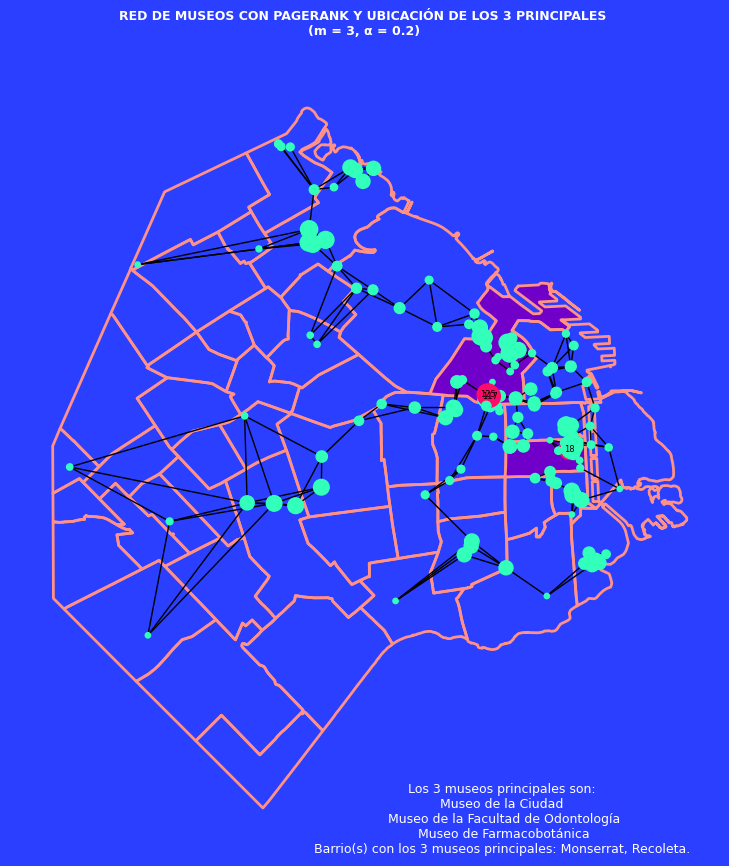

In [156]:
graficar_red_museos(3, 1/5)

### b)

In [23]:
# Tabla de ranking (contendrá los datos obtenidos)
ranking_museos = pd.DataFrame(columns=['museo','m_conexiones','alfa','pr','puesto', 'nombre_museo'])

lista_m = [1,3,5,10]
alfa = 1/5
Nprincipales = 3 # Cantidad de museos principales a identificar

# Datos de los museos
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
# Matriz de distancias
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy() 

for m in lista_m:  
    A = tf.construye_adyacencia(D,m)  # Matriz de adyacencia con los m museos más cercanos
    p = tf.calcula_pagerank(A, alfa)  # Vector de PageRank
    G = nx.from_numpy_array(A)  # Red a partir de la matriz de adyacencia        
    n_museos_principales = np.argsort(p)[-Nprincipales:] # Identifica a los N museos principales
    # Agregamos los datos a la tabla de ranking
    lista_posicion = ['tercero', 'segundo', 'primero']  # Para identificar más rápido el ranking para cada m y α 
    i = 0
    for indice in n_museos_principales:
        registro = { # Generamos los datos
            'museo': indice, 
            'm_conexiones': m,
            'alfa': alfa,
            'pr': p[indice],
            'puesto': lista_posicion[i],
            'nombre_museo': museos['name'].iloc[indice]
        }
        ranking_museos.loc[len(ranking_museos)] = registro  # Registramos al final de la tabla
        i += 1
display(ranking_museos)

museo  m_conexiones  alfa        pr   puesto  \
0      34             1   0.2  0.021288  tercero   
1     107             1   0.2  0.021706  segundo   
2      65             1   0.2  0.022124  primero   
3      18             3   0.2  0.021281  tercero   
4     125             3   0.2  0.023529  segundo   
5     117             3   0.2  0.024135  primero   
6     117             5   0.2  0.021066  tercero   
7     125             5   0.2  0.021614  segundo   
8      93             5   0.2  0.021736  primero   
9      15            10   0.2  0.018291  tercero   
10    135            10   0.2  0.018338  segundo   
11    124            10   0.2  0.018665  primero   

                                       nombre_museo  
0                 Museo Nacional de Arte Decorativo  
1   Museo del antiguo recinto del Congreso Nacional  
2                   Museo Nacional de Arte Oriental  
3                                Museo de la Ciudad  
4               Museo de la Facultad de Odontología  
5                          Museo de Farmacobotánica  
6                          Museo de Farmacobotánica  
7               Museo de la Facultad de Odontología  
8                              Museo de Odontología  
9                                 Museo Casa Rosada  
10                                Museo Franciscano  
11                       Museo Histórico de la AFIP

### c)

In [33]:
lista_alfas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
m = 5
Nprincipales = 3

# Mismo procedimiento que en el punto b) pero iterando sobre los alfas
for alfa in lista_alfas:  
    A = tf.construye_adyacencia(D,m)
    p = tf.calcula_pagerank(A, alfa)
    G = nx.from_numpy_array(A)    
    n_museos_principales = np.argsort(p)[-Nprincipales:] 
    lista_posicion = ['tercero', 'segundo', 'primero']  
    i = 0
    for indice in n_museos_principales:
        registro = {
            'museo': indice, 
            'm_conexiones': m, 
            'alfa': alfa, 
            'pr': p[indice], 
            'puesto': lista_posicion[i],
            'nombre_museo': museos['name'].iloc[indice]
        }
        ranking_museos.loc[len(ranking_museos)] = registro
        i += 1
display(ranking_museos)

museo  m_conexiones      alfa        pr   puesto  \
0      34             1  0.200000  0.021288  tercero   
1     107             1  0.200000  0.021706  segundo   
2      65             1  0.200000  0.022124  primero   
3      18             3  0.200000  0.021281  tercero   
4     125             3  0.200000  0.023529  segundo   
5     117             3  0.200000  0.024135  primero   
6     117             5  0.200000  0.021066  tercero   
7     125             5  0.200000  0.021614  segundo   
8      93             5  0.200000  0.021736  primero   
9      15            10  0.200000  0.018291  tercero   
10    135            10  0.200000  0.018338  segundo   
11    124            10  0.200000  0.018665  primero   
12     18             5  0.857143  0.008496  tercero   
13    135             5  0.857143  0.008496  segundo   
14    107             5  0.857143  0.008681  primero   
15     18             5  0.800000  0.009013  tercero   
16    135             5  0.800000  0.009013  segundo   
17    107             5  0.800000  0.009256  primero   
18    135             5  0.666667  0.010390  tercero   
19     18             5  0.666667  0.010390  segundo   
20    107             5  0.666667  0.010727  primero   
21    135             5  0.500000  0.012585  tercero   
22     93             5  0.500000  0.012601  segundo   
23    107             5  0.500000  0.012931  primero   
24    107             5  0.333333  0.015848  tercero   
25    125             5  0.333333  0.016112  segundo   
26     93             5  0.333333  0.016230  primero   
27    117             5  0.200000  0.021066  tercero   
28    125             5  0.200000  0.021614  segundo   
29     93             5  0.200000  0.021736  primero   
30    117             5  0.142857  0.025274  tercero   
31    125             5  0.142857  0.025781  segundo   
32     93             5  0.142857  0.025896  primero   

                                       nombre_museo  
0                 Museo Nacional de Arte Decorativo  
1   Museo del antiguo recinto del Congreso Nacional  
2                   Museo Nacional de Arte Oriental  
3                                Museo de la Ciudad  
4               Museo de la Facultad de Odontología  
5                          Museo de Farmacobotánica  
6                          Museo de Farmacobotánica  
7               Museo de la Facultad de Odontología  
8                              Museo de Odontología  
9                                 Museo Casa Rosada  
10                                Museo Franciscano  
11                       Museo Histórico de la AFIP  
12                               Museo de la Ciudad  
13                                Museo Franciscano  
14  Museo del antiguo recinto del Congreso Nacional  
15                               Museo de la Ciudad  
16                                Museo Franciscano  
17  Museo del antiguo recinto del Congreso Nacional  
18                                Museo Franciscano  
19                               Museo de la Ciudad  
20  Museo del antiguo recinto del Congreso Nacional  
21                                Museo Franciscano  
22                             Museo de Odontología  
23  Museo del antiguo recinto del Congreso Nacional  
24  Museo del antiguo recinto del Congreso Nacional  
25              Museo de la Facultad de Odontología  
26                             Museo de Odontología  
27                         Museo de Farmacobotánica  
28              Museo de la Facultad de Odontología  
29                             Museo de Odontología  
30                         Museo de Farmacobotánica  
31              Museo de la Facultad de Odontología  
32                             Museo de Odontología

**SEGUNDA PARTE DEL ENUNCIADO**

- Identifiquen los 3 museos más centrales (para cada m y cada α) y grafiquen sus puntajes (valores de Page Rank) en función del parametro a variar (es decir, en función de $m$ o de $\alpha$). 

- ¿Son estables las posiciones en el ranking?

- Describa los distintos patrones que observa, identificando qué ubicaciones son relevantes en
cada caso. ¿Hay museos que sólo son relevantes en redes con pocas conexiones?¿O
museos que se vuelven más relevantes mientras más conexiones aparecen?

In [34]:
# Esta celda tarda unos segundos en ejecutarse porque calcula varias veces p (para alfa= 1/5, m = 1,...,20)
# Generamos más datos de los pedidos para poder visualizar mejor el comportamiento del vector, pero termina!

# Datos de los museos
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')
# Matriz de distancias
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy() 

# Tabla de museos a analizar (contendrá los datos obtenidos)
tabla_museos_a_analizar = pd.DataFrame(columns=['museo','m_conexiones','alfa','pr','barrio','nombre_museo'])

# Luego de obtener los tres museos principales para cada variación de los parámetros m y alfa
# podemos generar una nueva tabla con los valores que tomaron en cada caso, aunque no se encuentren
# entre en los Nprincipales, para ver como varía su relevancia
lista_museos_a_analizar = ranking_museos.museo.unique()

# Repetimos los pasos c) y b), pero extrayendo los datos de los museos que nos interesan 
lista_m = list(range(1,21))  # Generamos datos para cada variación de m entre 1 y 20, con alfa = 1/5
alfa = 1/5
for m in lista_m:  
    A = tf.construye_adyacencia(D,m) 
    p = tf.calcula_pagerank(A, alfa) 
    G = nx.from_numpy_array(A)       
    for museo in lista_museos_a_analizar:
        # Obtenemos la ubicación del museo
        ubicacion_museo = museos.iloc[museo].geometry  
        # Obtenemos el barrio que contiene al museo
        barrio = barrios[barrios.geometry.contains(ubicacion_museo)]['nombre'].values[0]
        registro = {
            'museo': museo,
            'm_conexiones': m,
            'alfa': alfa,
            'pr': p[museo], 
            'barrio': barrio,
            'nombre_museo': museos['name'].iloc[museo]
        }
        # registro = {'museo': museo, 'm_conexiones': m,'alfa': alfa,'pr': p[museo]} 
        tabla_museos_a_analizar.loc[len(tabla_museos_a_analizar)] = registro  

lista_alfas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
m = 5
for alfa in lista_alfas:  
    A = tf.construye_adyacencia(D,m)
    p = tf.calcula_pagerank(A, alfa) 
    G = nx.from_numpy_array(A)      
    for museo in lista_museos_a_analizar:
        # Obtenemos la ubicación del museo
        ubicacion_museo = museos.iloc[museo].geometry  
        # Obtenemos el barrio que contiene al museo
        barrio = barrios[barrios.geometry.contains(ubicacion_museo)]['nombre'].values[0]
        registro = {
            'museo': museo, 
            'm_conexiones': m,
            'alfa': alfa, 
            'pr': p[museo], 
            'barrio': barrio,
            'nombre_museo': museos['name'].iloc[museo]
        }
        tabla_museos_a_analizar.loc[len(tabla_museos_a_analizar)] = registro  

display(tabla_museos_a_analizar)

museo  m_conexiones      alfa        pr     barrio  \
0       34             1  0.200000  0.021288    Palermo   
1      107             1  0.200000  0.021706  Monserrat   
2       65             1  0.200000  0.022124    Palermo   
3       18             1  0.200000  0.009967  Monserrat   
4      125             1  0.200000  0.003824   Recoleta   
..     ...           ...       ...       ...        ...   
265    117             5  0.142857  0.025274   Recoleta   
266     93             5  0.142857  0.025896   Recoleta   
267     15             5  0.142857  0.011289  Monserrat   
268    135             5  0.142857  0.021983  Monserrat   
269    124             5  0.142857  0.021721  Monserrat   

                                        nombre_museo  
0                  Museo Nacional de Arte Decorativo  
1    Museo del antiguo recinto del Congreso Nacional  
2                    Museo Nacional de Arte Oriental  
3                                 Museo de la Ciudad  
4                Museo de la Facultad de Odontología  
..                                               ...  
265                         Museo de Farmacobotánica  
266                             Museo de Odontología  
267                                Museo Casa Rosada  
268                                Museo Franciscano  
269                       Museo Histórico de la AFIP  

[270 rows x 6 columns]

#### Gráfico 3.0

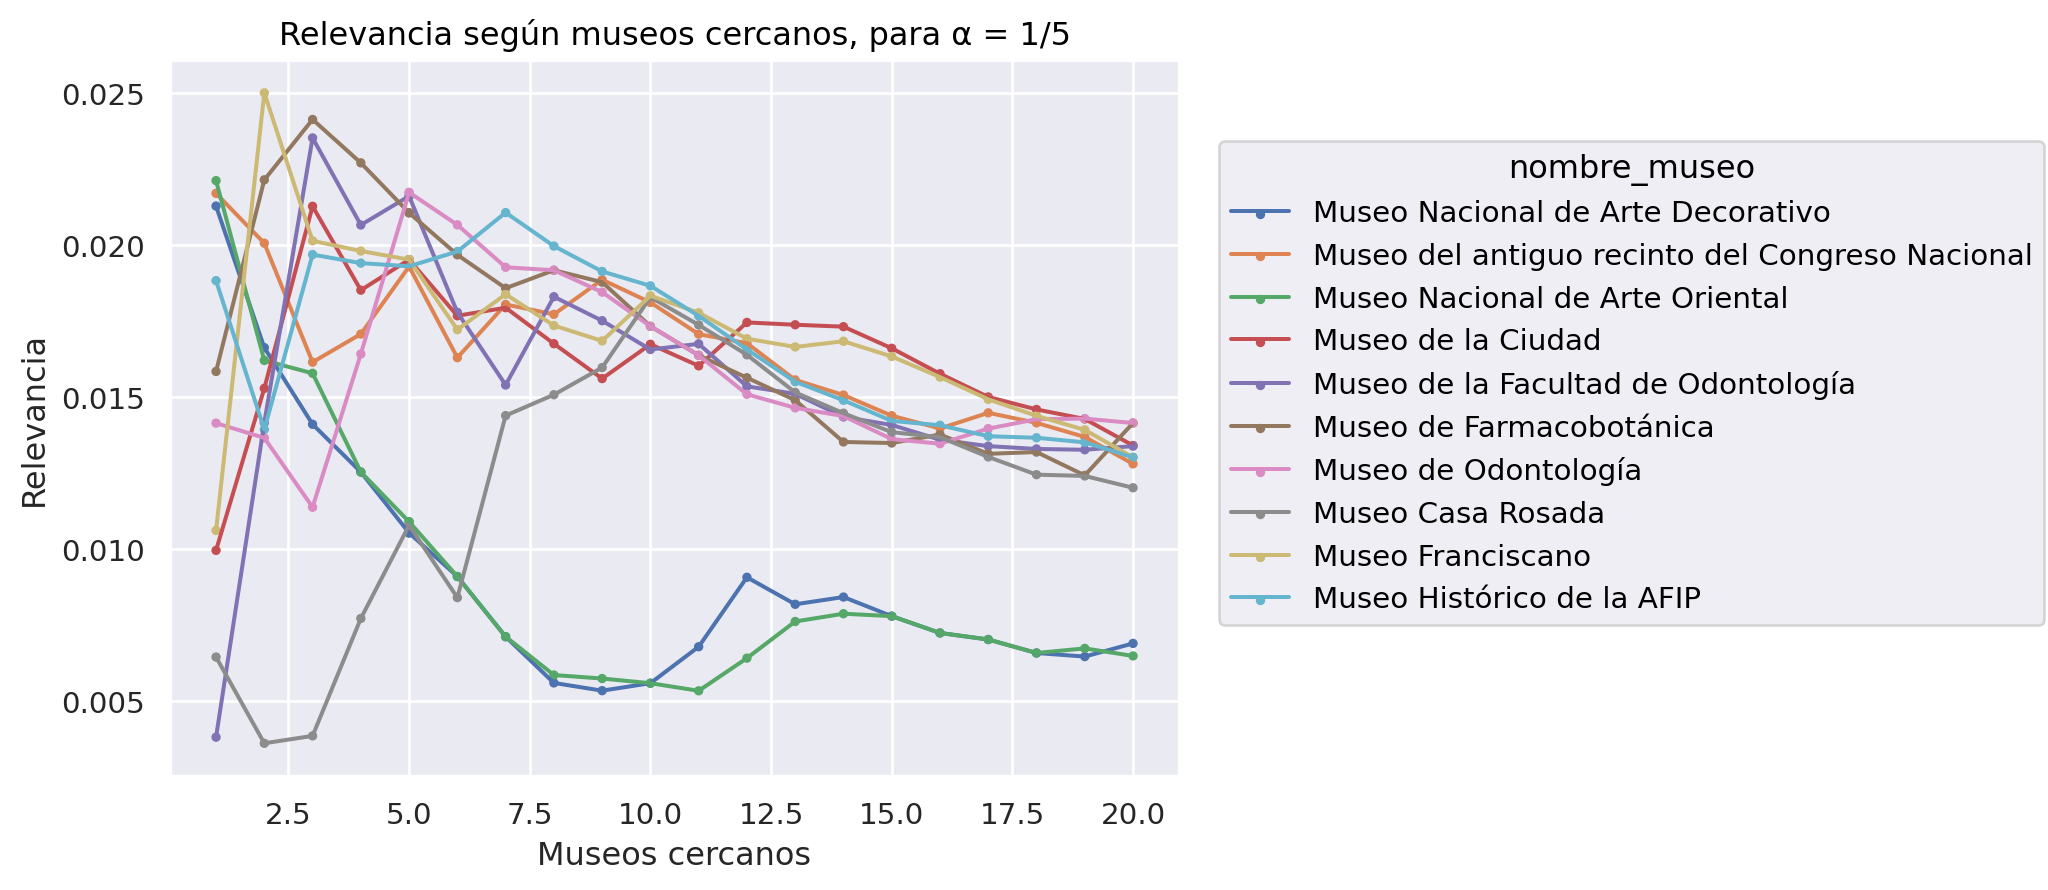

In [37]:
# Hacemos los gráficos en seaborn.objects como nos enseñaron en el labo de datos
# Despues tendríamos que convertirlos a seaborn original o preguntar el martes si podemos usar esta librería
import seaborn.objects as so

# Para alfa = 1/5, nos quedamos solo con las columnas indicadas y reiniciamos los índices
ranking_alfa_un_quinto = tabla_museos_a_analizar.loc[
    tabla_museos_a_analizar.alfa == 1/5, 
    ['museo','m_conexiones', 'pr', 'barrio', 'nombre_museo']
].reset_index(drop=True)

# Convertimos los indices a texto para prevenir que arme un degragado
# y nos de un color diferente para cada uno de los museos
ranking_alfa_un_quinto['museo'] = ranking_alfa_un_quinto['museo'].astype(str)

# Visualizamos
(
    so.Plot(ranking_alfa_un_quinto, 'm_conexiones', 'pr', group='nombre_museo', color='nombre_museo')
    .add(so.Line())
    .add(so.Dot(pointsize=3))
    .label(
        x = 'Museos cercanos',
        y = 'Relevancia',
        title = 'Relevancia según museos cercanos, para α = 1/5'
    )
)

#### Gráfico 3.1

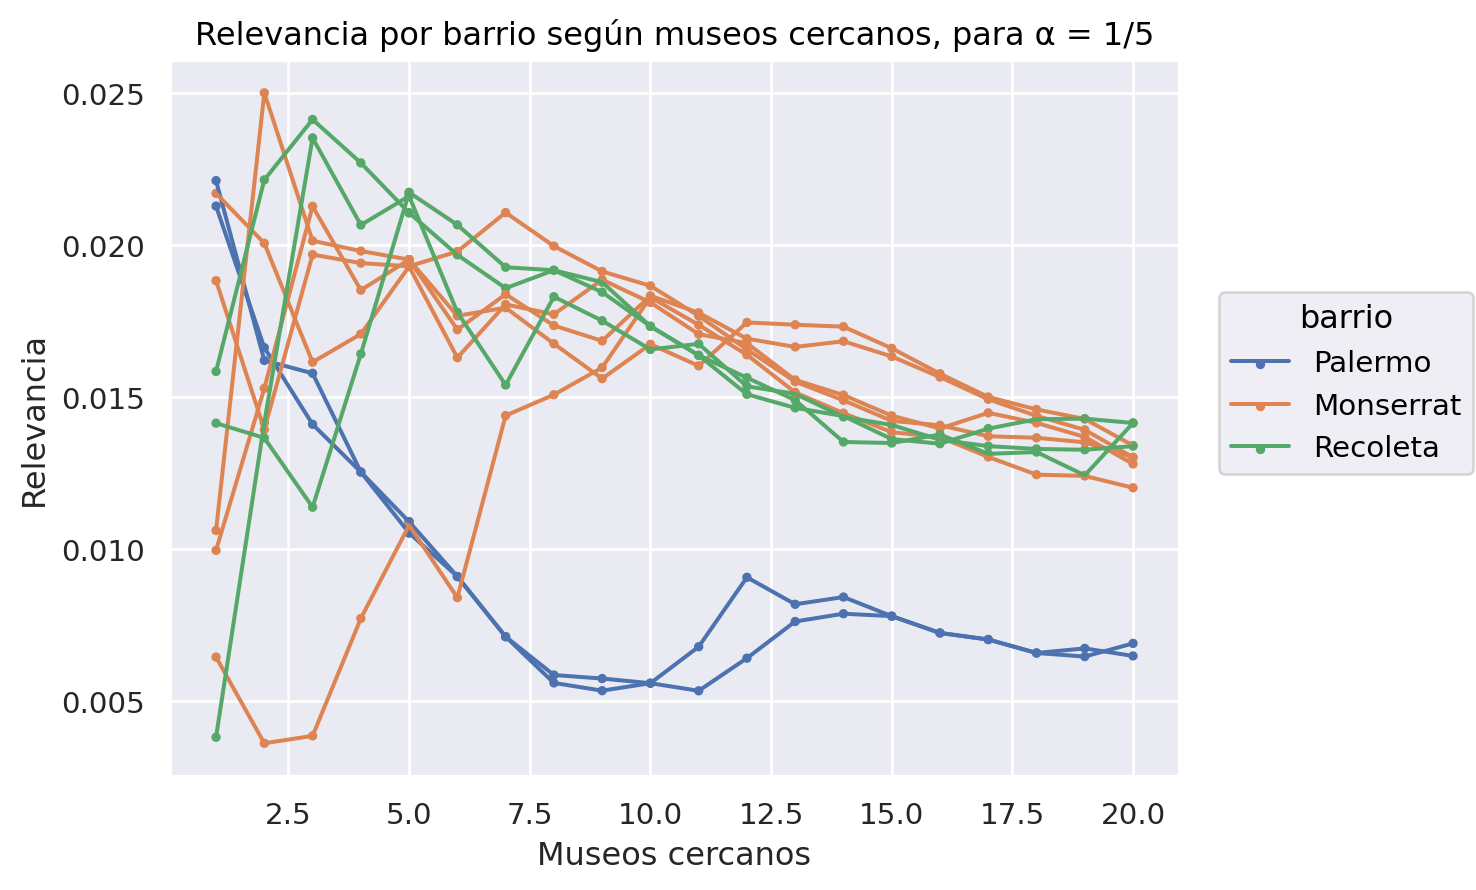

In [41]:
# Visualizamos por barrio
(
    so.Plot(ranking_alfa_un_quinto, 'm_conexiones', 'pr', group='museo', color='barrio')
    .add(so.Line())
    .add(so.Dot(pointsize=3))
    .label(
        x = 'Museos cercanos',
        y = 'Relevancia',
        title = 'Relevancia por barrio según museos cercanos, para α = 1/5'
    )
)

#### Gráfico 3.2

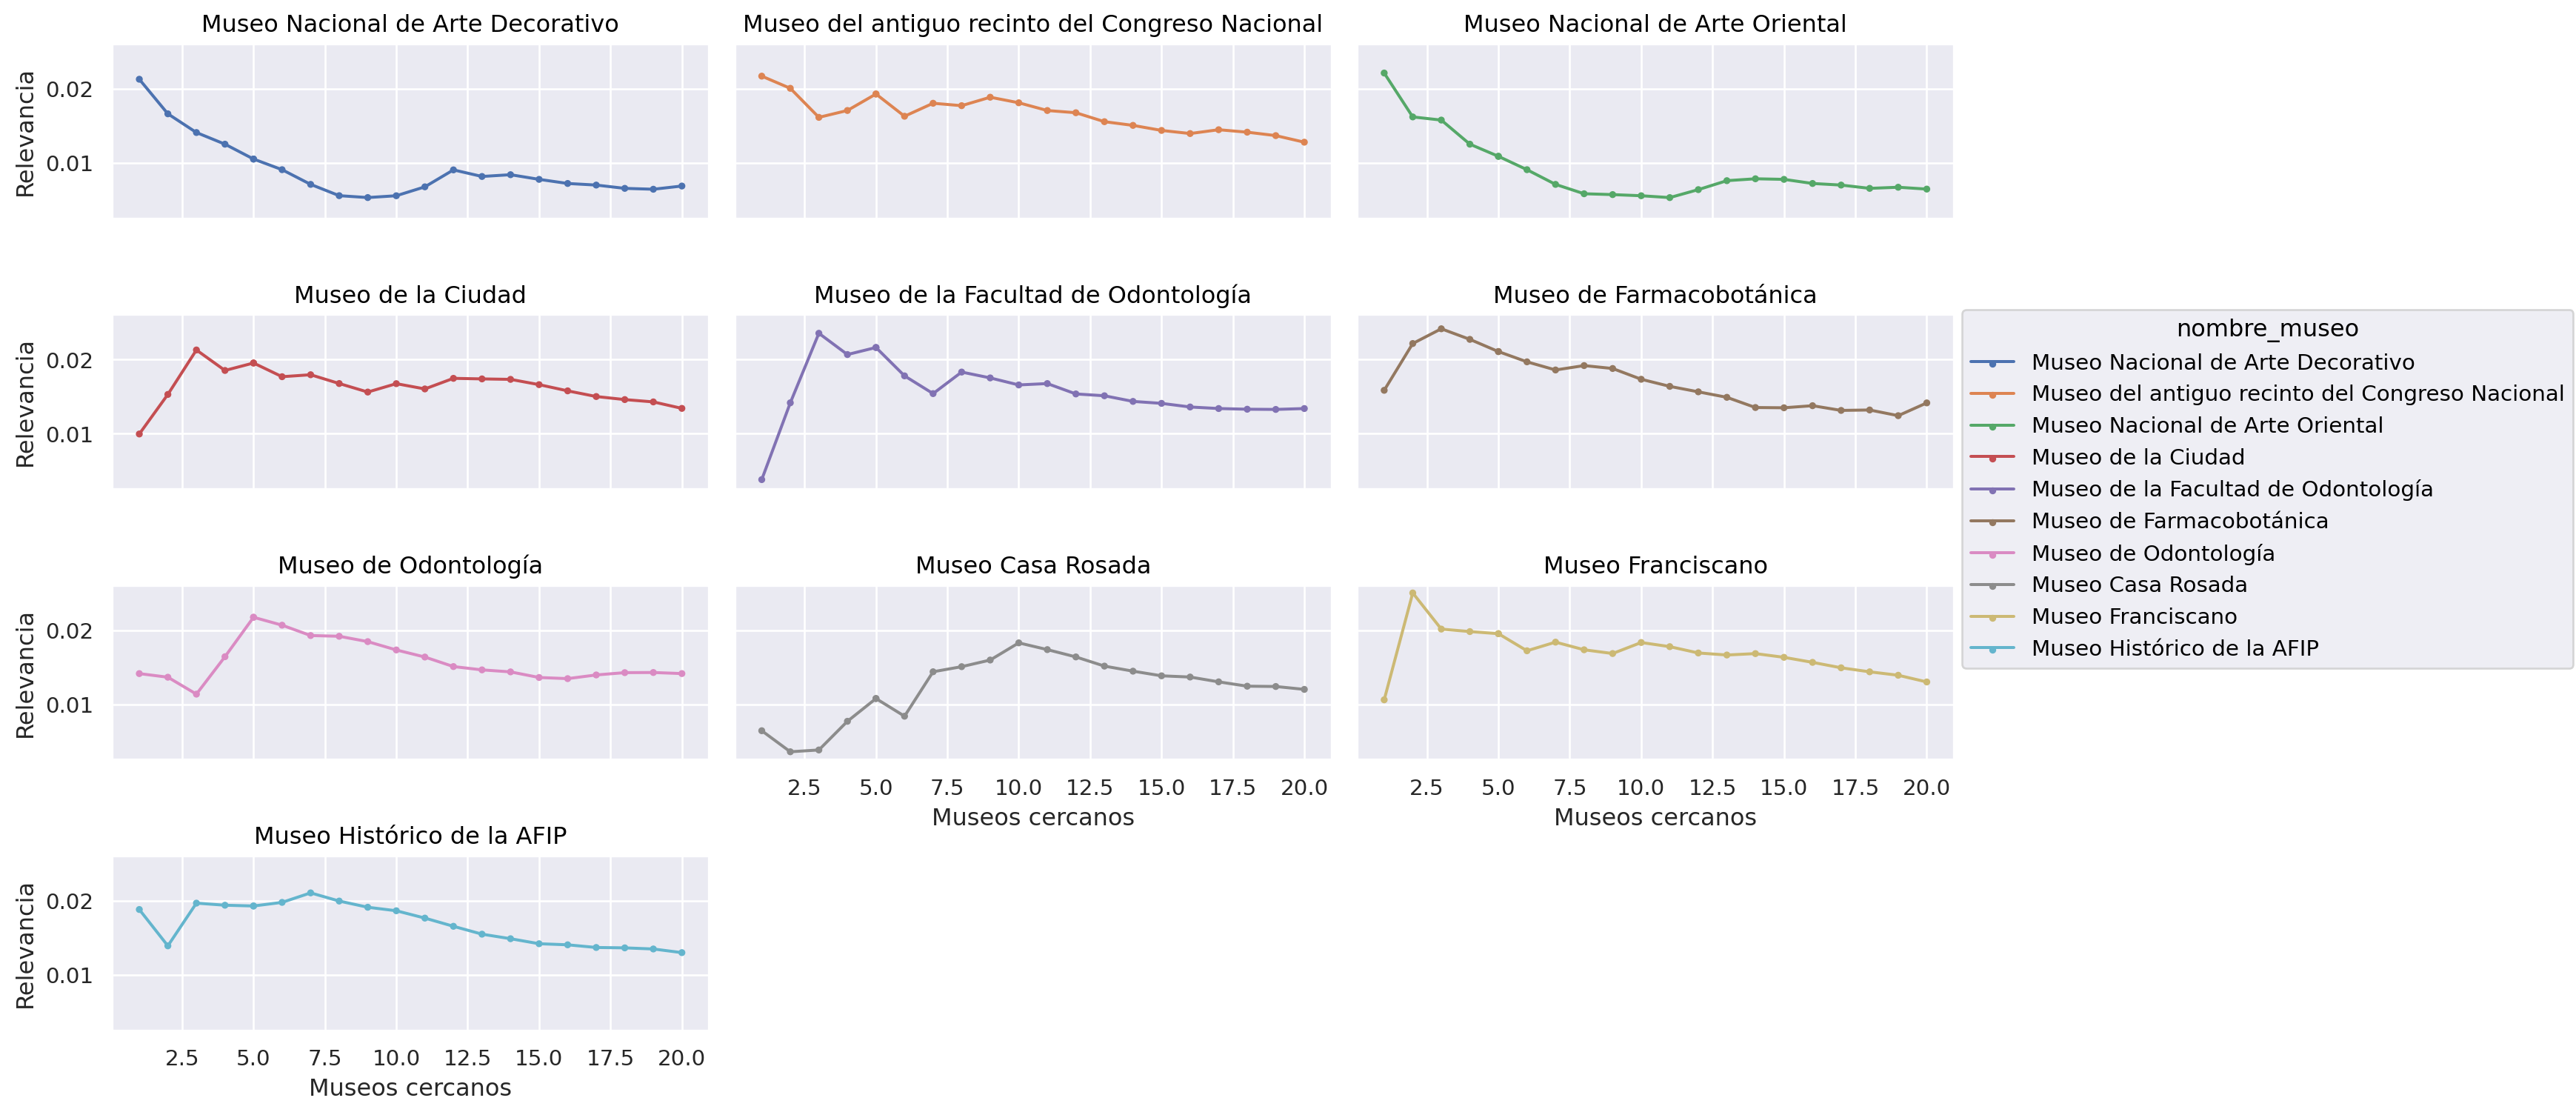

In [38]:
# Graficamos los principales museos por separado para poder interpretar mejor los datos
(
    so.Plot(ranking_alfa_un_quinto, 'm_conexiones', 'pr', group='nombre_museo', color='nombre_museo')
    .add(so.Line())
    .add(so.Dot(pointsize=3))
    .facet('nombre_museo', wrap=3)
    .layout(size=(14, 8))
    .label(
        x = 'Museos cercanos',
        y = 'Relevancia',
    )
)

#### Para $\alpha = \frac{1}{5}$:
- La variación en la relevancia es mas intensa cuando se la calcula para unos pocos museos cercanos (menos de 10). El rango con variación mas extrema en todos los casos sucede para menos de 5 museos.
- En el **gráfico 3.0** se pueden distinguir dos grande grupos: uno *(107, 18, 125, 117, 93, 15, 135, 124, ubicados en Recoleta y Monserrat)* en el cual la medida de relevancia tiende a tomar valores similares (altos) a medida que aumenta el número de museos cercanos, y otro *(34 y 65, ambos ubicados en el límite entre Palermo y Recoleta)* cuya relevancia (muy alta) tiende a disminuir significativamente a medida que se consideran más museos.
- La distinción entre los dos grupos se ve con más claridad para valores de $m > 5$.

#### Gráfico 3.3

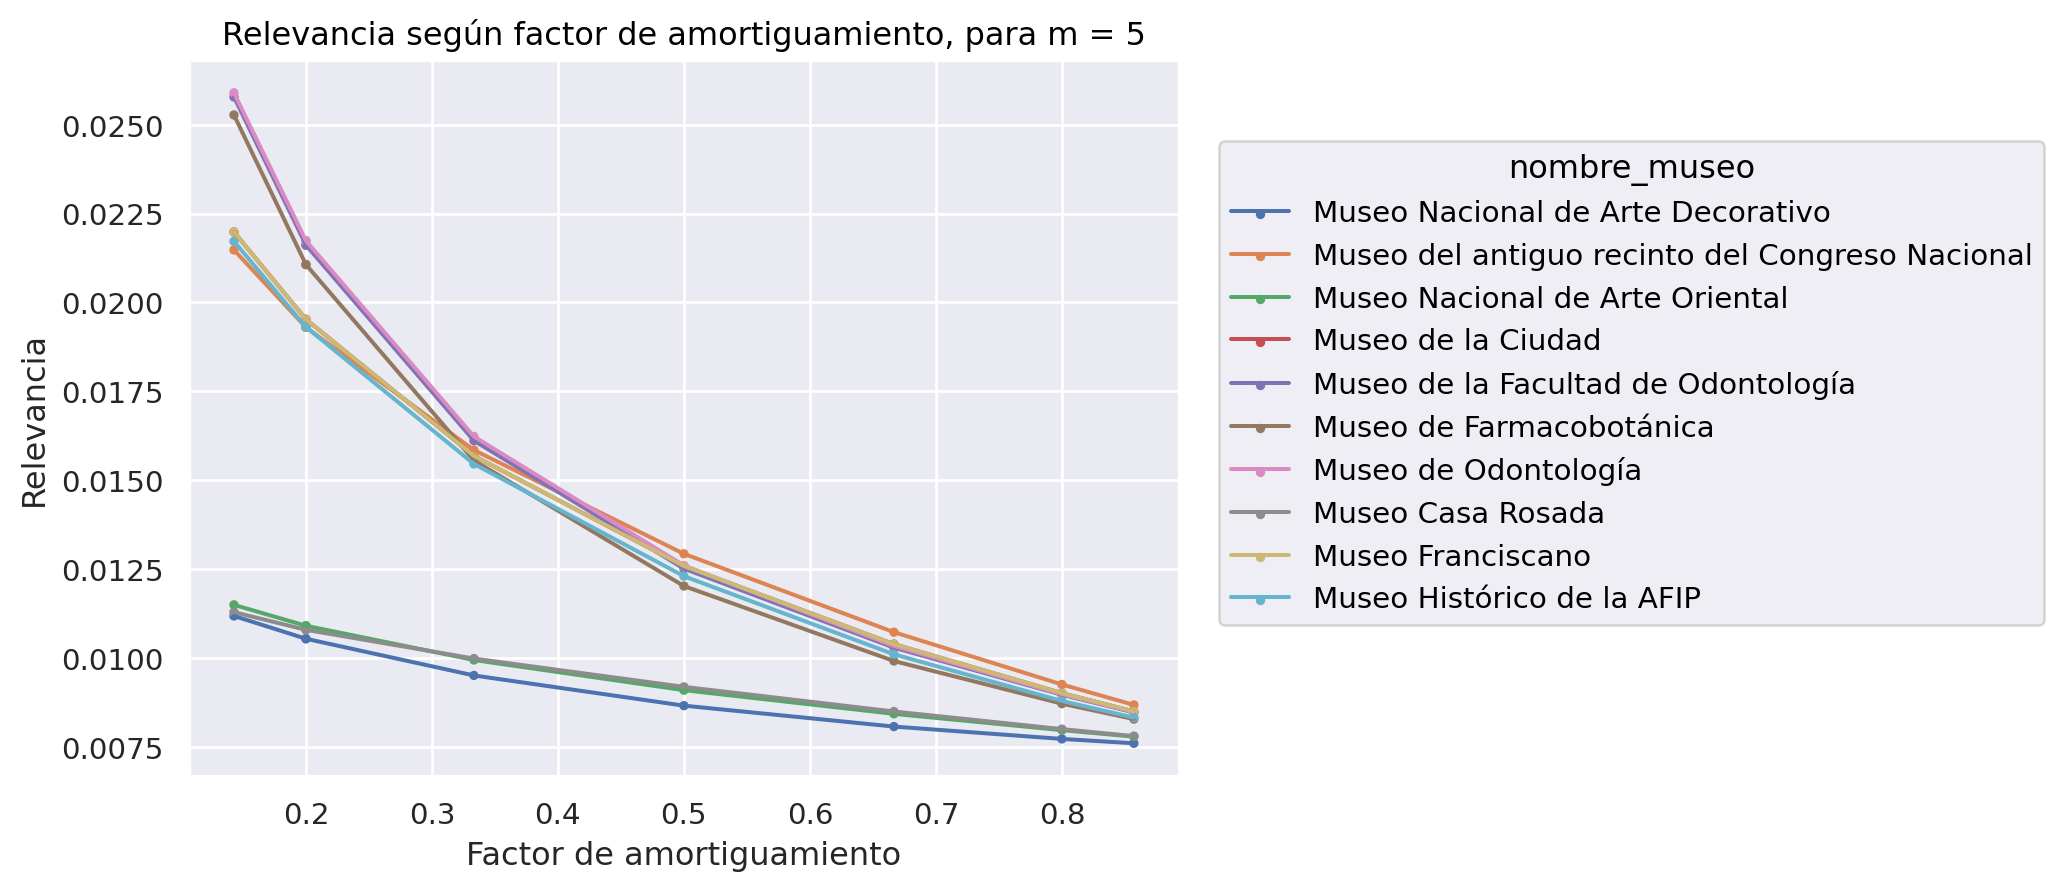

In [40]:
ranking_m5 = tabla_museos_a_analizar.loc[
    tabla_museos_a_analizar.m_conexiones == 5, 
    ['museo','alfa', 'pr','nombre_museo']
].reset_index(drop=True)
ranking_m5['museo'] = ranking_m5['museo'].astype(str)

(
    so.Plot(ranking_m5, 'alfa', 'pr', group='nombre_museo', color='nombre_museo')
    .add(so.Line())
    .add(so.Dot(pointsize=3))
    .label(
        x = 'Factor de amortiguamiento',
        y = 'Relevancia',
        title = 'Relevancia según factor de amortiguamiento, para m = 5'
    )
)

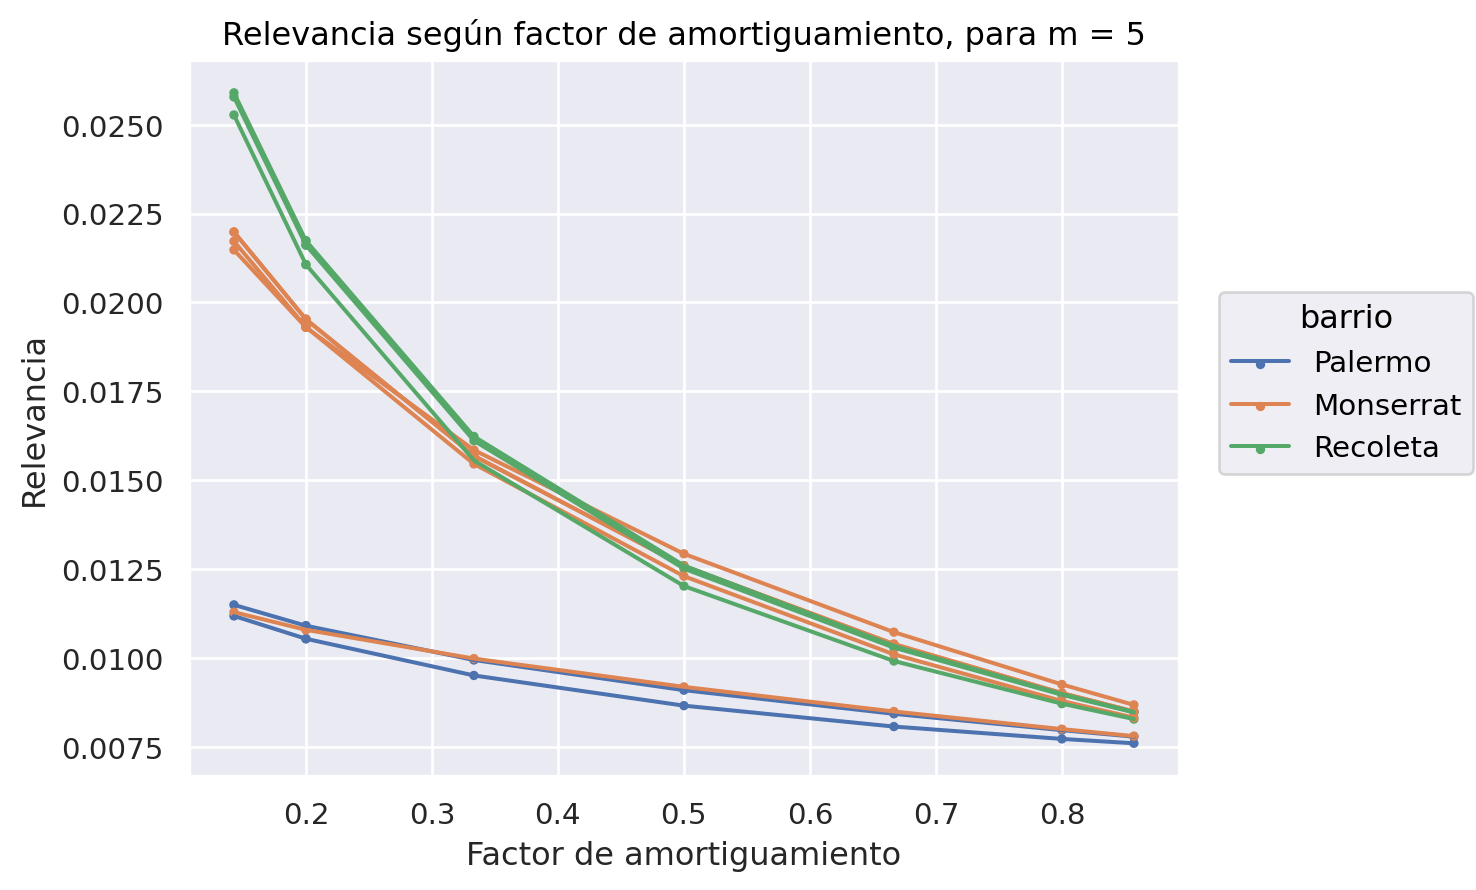

In [41]:
ranking_m5 = tabla_museos_a_analizar.loc[
    tabla_museos_a_analizar.m_conexiones == 5, 
    ['museo','alfa', 'pr', 'barrio']
].reset_index(drop=True)
ranking_m5['museo'] = ranking_m5['museo'].astype(str)

(
    so.Plot(ranking_m5, 'alfa', 'pr', group='museo', color='barrio')
    .add(so.Line())
    .add(so.Dot(pointsize=3))
    .label(
        x = 'Factor de amortiguamiento',
        y = 'Relevancia',
        title = 'Relevancia según factor de amortiguamiento, para m = 5'
    )
)

#### Para $m=5$:
- Se identifican nuevamente dos tendencias claras, cuya relevancia relativa tiene un comportamiento similar en función de alfa.

**TERCERA PARTE DEL ENUNCIADO**

Construyan visualizaciones del mapa, usando el Page Rank para representar el tamaño de cada museo. ¿Qué regiones se vuelven más predominantes al aumentar $\alpha$? ¿Y al aumentar $m$?

### **DESARROLLO**

Para empezar, obtenemos algunos datos generales de la tabla que construimos, quedandonos solo con las filas en que $m \le 10$ (donde se ve más variabilidad). Tanto para las variaciones de m como de alfa, los museos principales se encuentran en:

In [45]:
datos_hasta_m10 = tabla_museos_a_analizar[tabla_museos_a_analizar.m_conexiones <= 10].reset_index(drop=True)
print(f'{', '.join(datos_hasta_m10.barrio.unique())}.')

Palermo, Monserrat, Recoleta.


A continuación, se lista la cantidad de veces que cada uno de ellos apareció entre los **barrios con alguno de los tres museos más relevantes**:

In [46]:
print(datos_hasta_m10.barrio.value_counts())

barrio
Monserrat    85
Recoleta     51
Palermo      34
Name: count, dtype: int64


Para distintos valores de $m$, los **museos principales** fueron los siguientes: *(ver **Gráficos del 3.4 al 3.8: variación de m**)*

In [51]:
lista_m = datos_hasta_m10.m_conexiones.unique()
for m in lista_m:
    principal = datos_hasta_m10.loc[datos_hasta_m10[datos_hasta_m10.m_conexiones == m]['pr'].idxmax(), ['museo', 'barrio', 'alfa','pr','nombre_museo']]
    print(f'Para m = {m}, alfa = {np.round(principal['alfa'], 3)}, el {principal['nombre_museo']} ubicado en {principal['barrio']}, tiene el ranking más alto: {np.round(principal['pr'], 4)}.\n')

Para m = 1, alfa = 0.2, el Museo Nacional de Arte Oriental ubicado en Palermo, tiene el ranking más alto: 0.0221.

Para m = 2, alfa = 0.2, el Museo Franciscano ubicado en Monserrat, tiene el ranking más alto: 0.025.

Para m = 3, alfa = 0.2, el Museo de Farmacobotánica ubicado en Recoleta, tiene el ranking más alto: 0.0241.

Para m = 4, alfa = 0.2, el Museo de Farmacobotánica ubicado en Recoleta, tiene el ranking más alto: 0.0227.

Para m = 5, alfa = 0.143, el Museo de Odontología ubicado en Recoleta, tiene el ranking más alto: 0.0259.

Para m = 6, alfa = 0.2, el Museo de Odontología ubicado en Recoleta, tiene el ranking más alto: 0.0207.

Para m = 7, alfa = 0.2, el Museo Histórico de la AFIP ubicado en Monserrat, tiene el ranking más alto: 0.0211.

Para m = 8, alfa = 0.2, el Museo Histórico de la AFIP ubicado en Monserrat, tiene el ranking más alto: 0.02.

Para m = 9, alfa = 0.2, el Museo Histórico de la AFIP ubicado en Monserrat, tiene el ranking más alto: 0.0191.

Para m = 10, alfa =

Para distintos valores de $\alpha$, los **museos principales** fueron los siguientes: *(ver **Gráficos del 3.9 al 3.14: variación de** $\alpha$)*

In [52]:
lista_alfas = datos_hasta_m10.alfa.unique()
for alfa in lista_alfas:
    principal = datos_hasta_m10.loc[datos_hasta_m10[datos_hasta_m10.alfa == alfa]['pr'].idxmax(), ['museo', 'barrio', 'alfa', 'pr', 'nombre_museo']]
    print(f'Para m = 5, alfa = {np.round(principal['alfa'], 3)}, el {principal['nombre_museo']} ubicado en {principal['barrio']}, tiene el ranking más alto: {np.round(principal['pr'], 4)}.\n')

Para m = 5, alfa = 0.2, el Museo Franciscano ubicado en Monserrat, tiene el ranking más alto: 0.025.

Para m = 5, alfa = 0.857, el Museo del antiguo recinto del Congreso Nacional ubicado en Monserrat, tiene el ranking más alto: 0.0087.

Para m = 5, alfa = 0.8, el Museo del antiguo recinto del Congreso Nacional ubicado en Monserrat, tiene el ranking más alto: 0.0093.

Para m = 5, alfa = 0.667, el Museo del antiguo recinto del Congreso Nacional ubicado en Monserrat, tiene el ranking más alto: 0.0107.

Para m = 5, alfa = 0.5, el Museo del antiguo recinto del Congreso Nacional ubicado en Monserrat, tiene el ranking más alto: 0.0129.

Para m = 5, alfa = 0.333, el Museo de Odontología ubicado en Recoleta, tiene el ranking más alto: 0.0162.

Para m = 5, alfa = 0.143, el Museo de Odontología ubicado en Recoleta, tiene el ranking más alto: 0.0259.



A continuación se muestran las visualizaciones que permiten observar lo descrito: los barrios cuyos museos han tenido mayor relevancia en las redes, se encuentran en la **zona noreste** de la Capital Federal, que **concentra la mayor cantidad de museos**, muy próximos unos de otros.

#### VARICIÓN EN $m$

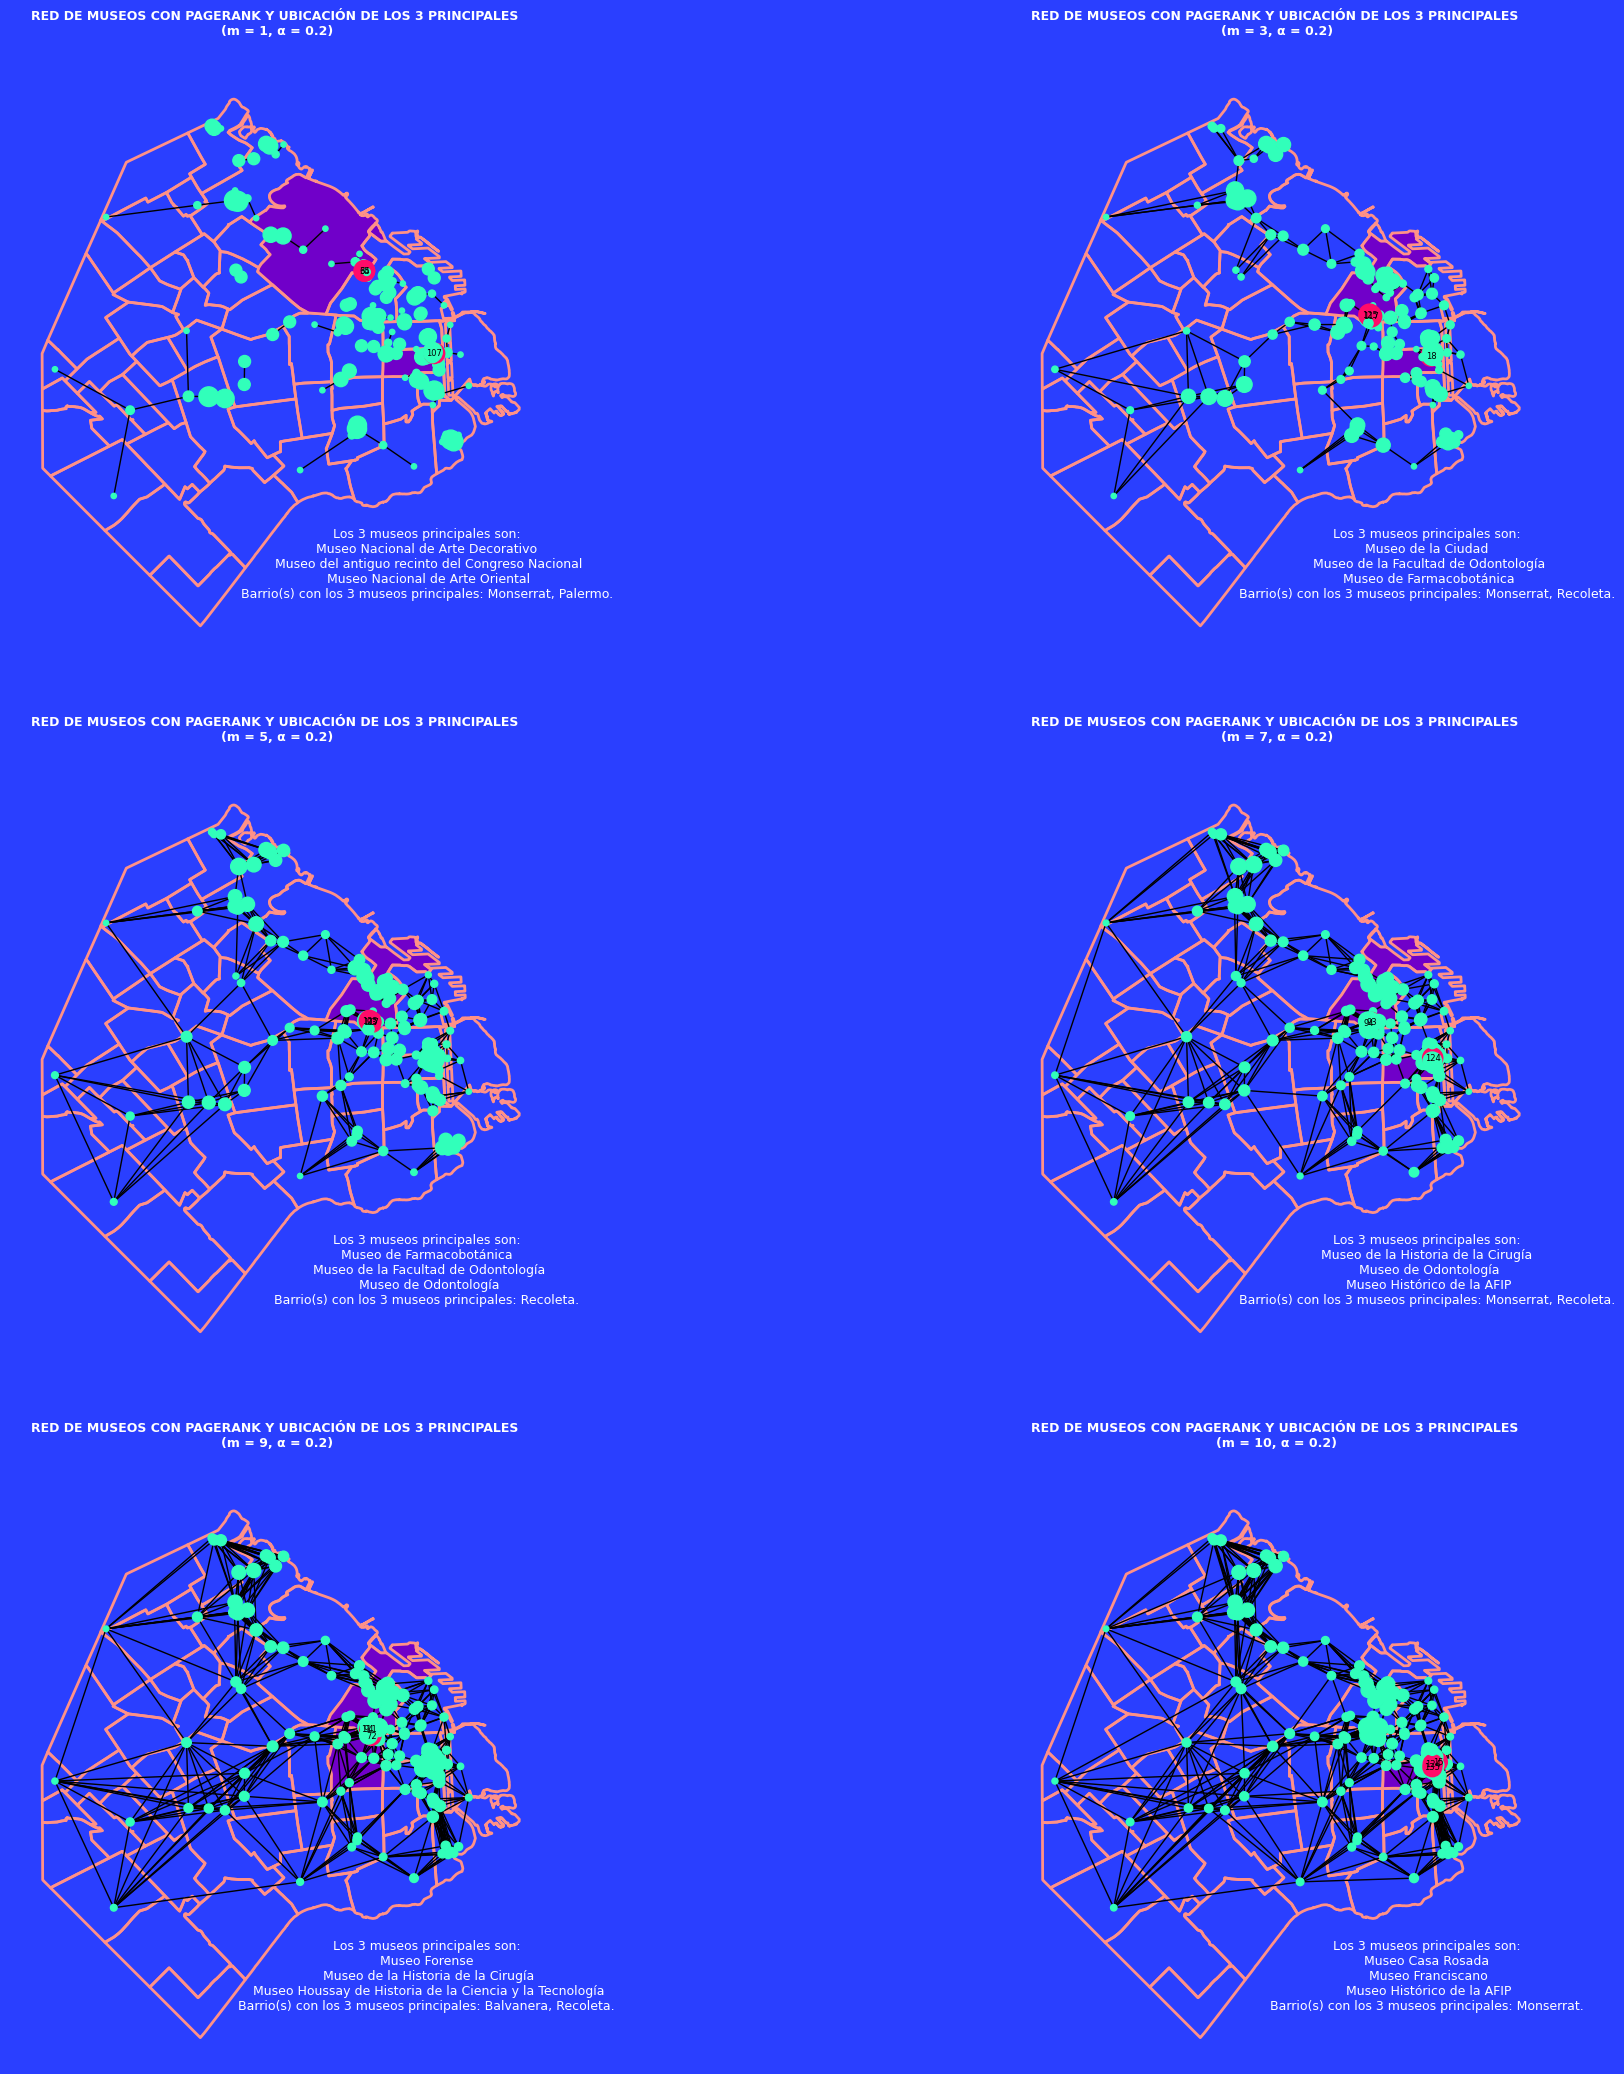

In [157]:
# Mostramos la variación de m en un solo gráfico
parametros_vari_m = {  # Alamacena los argumentos de cada llamada a  graficar_red_museos()
    0 : (1, 1/5),  # Variaciones de m
    1 : (3, 1/5),
    2 : (5, 1/5),
    3 : (7, 1/5),
    4 : (9, 1/5),
    5 : (10, 1/5),
}

grafico_comparativo = plt.figure(figsize=(20,20), facecolor='#2a3fff')
subfiguras = grafico_comparativo.subfigures(3, 2, wspace=0)  # Devuelve un arreglo de (3,2)

subfiguras = subfiguras.flatten()  # arreglo de (6,)
for i in range(6):
    eje = subfiguras[i].add_subplot(111)
    graficar_red_museos(*parametros_vari_m[i], ax=eje, fig=subfiguras[i])

plt.tight_layout()
plt.show()

Para $\alpha$ fijo en $\displaystyle \frac{1}{5}$, a medida que $m$ aumenta, la **región predominante** se traslada de Palermo hacia Recoleta ($1 < m < 6$), y de Recoleta a Monserrat ($m > 6$).

#### VARICIÓN EN $\alpha$

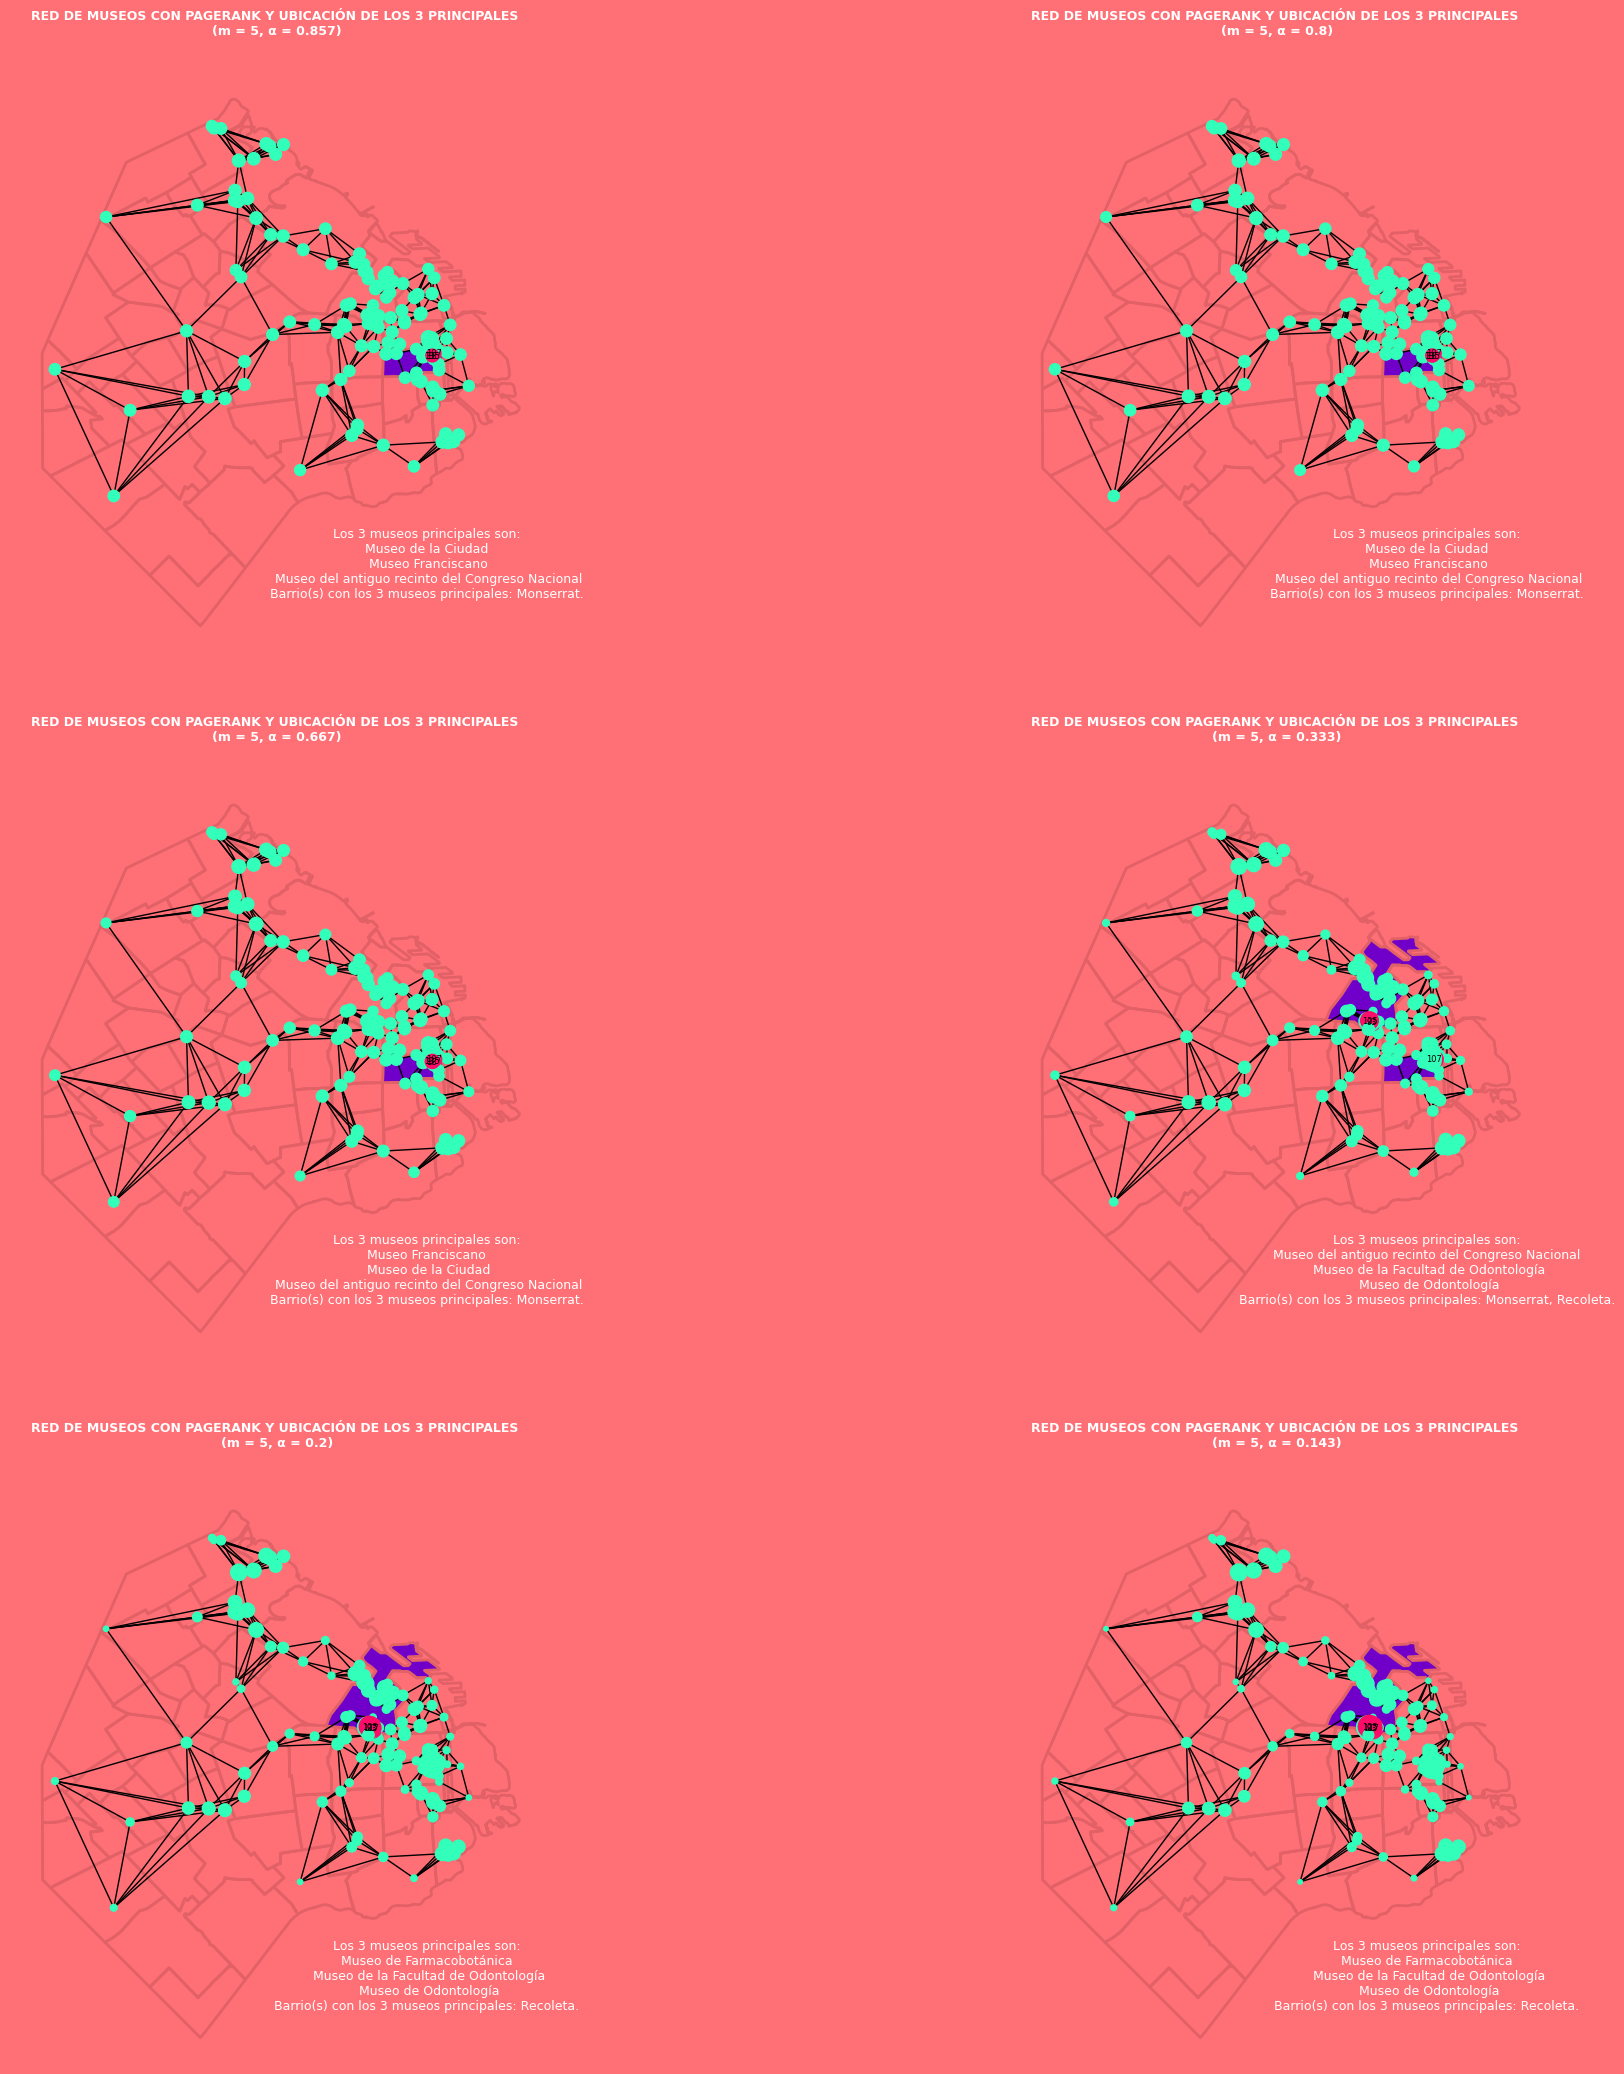

In [158]:
# Mostramos la variación de alpha en un solo gráfico
parametros_vari_a = {  # Alamacena los argumentos de cada llamada a  graficar_red_museos()
    0 : (5,6/7, {'color_fondo':'#ff6f76', 'color_barrio_relevante':'#7000c9', 'color_limite_barrial':'#e16167'}),  # Variaciones de alfa
    1 : (5,4/5, {'color_fondo':'#ff6f76', 'color_barrio_relevante':'#7000c9', 'color_limite_barrial':'#e16167'}),
    2 : (5,2/3, {'color_fondo':'#ff6f76', 'color_barrio_relevante':'#7000c9', 'color_limite_barrial':'#e16167'}),
    3 : (5,1/3, {'color_fondo':'#ff6f76', 'color_barrio_relevante':'#7000c9', 'color_limite_barrial':'#e16167'}),
    4 : (5,1/5, {'color_fondo':'#ff6f76', 'color_barrio_relevante':'#7000c9', 'color_limite_barrial':'#e16167'}),
    5 : (5,1/7, {'color_fondo':'#ff6f76', 'color_barrio_relevante':'#7000c9', 'color_limite_barrial':'#e16167'})
}

grafico_comparativo = plt.figure(figsize=(20,20), facecolor='#ff6f76')
subfiguras = grafico_comparativo.subfigures(3, 2, wspace=0)  # Devuelve un arreglo de (3,2)

subfiguras = subfiguras.flatten()  # arreglo de (6,)
for i in range(6):
    eje = subfiguras[i].add_subplot(111)
    graficar_red_museos(
        parametros_vari_a[i][0],
        parametros_vari_a[i][1],
        ax=eje,
        fig=subfiguras[i],
        **parametros_vari_a[i][2]
    )

plt.tight_layout()
plt.show()

Para $m$ fijo en 5, a medida que el **factor de amortiguamiento** disminuye, la **zona de relevancia** se traslada de Monserrat a Recoleta.

Como es posible intuir mirando la distribución de los museos de la ciudad, la **región** que contiene a los barrios (**zonas de relevancia**) con puntaje más alto, es la **zona noreste** de la Capital Federal, con fluctuaciones de un barrio a otro en función de $m$ o $\alpha$, pero siempre entre Monserrat, Recoleta y el límite entre Palermo y Recoleta. La interpretación incial que sugiere el mapa se ve corroborada por los datos. 

## Punto 4:

---
Partiendo de la ecuación 
$$ v = B^{-1}w $$
Además, considerando a B inversible y multiplicandola a ambos lados de la igualdad, obtenemos que:
$$ w = B.v $$

A través de esta ecuación nos proponemos demostrar que este valor de w siempre se cumple. 

Iniciamos desde el nuestro inicial v, el cual tiene en la posición i la cantidad de personas que tienen al museo i como su primera opción. <br>
Para profundizar, observamos el comportamiento y la relación entre cada paso y visita...
- $ \text{Inicio: v0 = } C^{0}.v_0  $  1ra visita
- $ \text{Primer paso: } v_1= C^{1}.v_0 $  2da visita
- $ \text{Segundo paso: } v_2 = C^{1}.v1 = C^{1}.C^{1}.v_0 = C^{2}.v_0 $  3ra visita
- $ \text{Tercer paso: }v_3 = C^{1}.v2 = C^{1}.C^{2}.v_0 = C^{3}.v_0$  4ta visita

  . . .

- $\text{Paso k-1, } v_k = C^{k-1}*v $ k visita 
- $\text{Paso k, } v_k = C^{k}*v $ k+1 visita 
$$\text{Entonces podemos observar que... }$$
$$
\boxed{
\text{Cada paso está determinado por }v_{n}=C*v_{n-1}, \text{ con v0 momento inicial.}
}
$$
Es necesario determinar qué componentes se están multiplicando en la operación...
$$
C = \begin{bmatrix}
c_{11} & \dots & c_{1m} \\
\vdots & \ddots & \vdots \\
a_{n1} & \dots & a_{nm} \\
\end{bmatrix}
, v_{k-1} = \begin{bmatrix}
(v_{k-1})_1 \\
\vdots \\
(v_{k-1})_n
\end{bmatrix}
$$
Vemos con nuestra primer componente:
$ (v_{k})_1 = c_{11}*(v_{k-1})_{1}  + c_{12}*(v_{k-1})_2  + ... + c_{1m}*(v_{k-1})_n $ <br>
Lo cual es equivalente, pensandolo según las columnas de la matriz C, y estudiando la probabilidad de ir al museo j desde i...: <br>
$$ (v_{k})_1 = c_{11}*(v_{k-1})_{1}  + c_{21}*(v_{k-1})_2  + ... + c_{n1}*(v_{k-1})_n $$

En ese caso, podemos obtenemos la siguiente sumatoria:
$$ 
\boxed{
 (v_{k})_{i} = \sum_{j}^{} C_{ji}*(v_{k-1})_{j}
}
$$

Si queremos calcular la cantidad total de visitantes que recibio cada museo (w) planteamos la suma de los pasos de los visitantes, que equivalen a las los pasos hechos por los visitantes a cada uno de los museos.

En nuestro caso wi puede expresar como la suma de las componentes i de los vectores v

Por ejemplo, si tomamos i=1, w1 = primer elemento de v0 + primer elemento de v1... 

$$ w_{i} = \sum_{k}^{} (v_{k})_{i} = \sum_{k}^{} \sum_{j}^{} C_{ji}*(v_{k-1})_{j} $$

Reagrupandolo obtenemos: 

$$  w_{i} = \sum_{j}^{}C_{ji} * \sum_{k}^{}(v_{k-1})_{j} $$

Vemos, según el análisis anterior, que esta sumatoria también es equivalente a:
$$ = \sum_{k}^{} C^k * v $$

---
Luego, nos queda estudiar el comportamiento general de la sumatoria de pasos.
- Consideramos una cantidad *r* de pasos, tomamos k=r-1, es decir k=0,1,2,...,r-1

$$
w = \sum_{i=0}^{r-1} v_{i} = v_0 + v_1 + v_2 + ... + v_(r-1) 
$$
La suma de vectores da un vector

\begin{aligned}
v_0 = C^0.v_0 \\
+ \\
v_1 = C^1.v_0 \\
+ \\
v_2 = C^2.v_0 \\
+ \\
v_3 = C^3.v_0 \\
+ \\
\vdots \\
+ \\
v_k = C^(r-1).v \\
\hline
C^0.v+ C^1.v+ C^2.v + ... + C^(r-1).v \\
(I + C^1 + C^2 + ... + C^(r-1)).v \\
= \sum_{k=0}^{r-1} C^k * v
\end{aligned}

Vemos la forma de nuestra primer componente:
$ (w)_1 = c_{11}*(v)_{1}  + c_{12}*(v)_2  + ... + c_{1m}*(v_{0})_n $

Vemos que multiplicamos cada fila de la matriz C a la k por las componentes del vector v0.
Lo cual lo definimos como:
$$
w_{i} = \sum_{k}^{} \sum_{j}^{} C_{ij}^{k} * (v_{0})_{j}
$$

Reagrupamos

$$ w_{i} = \sum_{j}^{} (v_{0})_{j} \sum_{k}^{} C_{ij}^{k} $$

Aquello es equivalente a pensar la distribucion de nuestro vector B*v
$$ = \sum_{k}^{} C^k * v $$


## Punto 5:

### Enunciado

Usando la **Eq. 5**, y suponiendo que las personas dan $r = 3$ pasos en la red de museos, calcular la cantidad total de visitantes que entraron en la red, $||v||1$, a partir del vector $w$ provisto en el archivo `visitas.txt`. Usar para esto la matriz de transiciones definida
por la **Eq. 4**. Para esto:

- **(i)** Construya una función `calcula_matriz_C_continua()` que reciba la matriz de distancias entre museos $D$ y retorne la matriz $C$ definida en la **Eq. 4**.
- **(ii)** Construya una función `calcula_B(C,r)` que reciba la matriz $C$ y el número de pasos $r$ como argumento, y retorne la matriz $B$ de la **Eq. 5**.
- **(iii)** Utilice la función `calculaLU()` para resolver la **Eq. 5**.

### **Desarrollo**

#### **Ecuación 4**

1. $$\quad\displaystyle C_{ji} = \underbrace{P(i\to j)}_{\substack{\text{probabilidad}\\\text{de transición}\\\text{de $i$ a $j$}}} = \begin{cases} \frac{f(d_{ij})}{\displaystyle \sum_{\substack{k=1,\\ k\ne i}}^{n} f(d_{ik})}\quad \text{para $j\ne i$} \\ \\ 0 \quad \text{ para $j = i$ (no se puede ir del museo $i$ al $i$)}  \end{cases}$$

2. Por la introducción tenemos que: $$f(d_{ji}) = d_{ji}^{-1}, \quad \displaystyle A_{ij} = f(d_{ij}) = \frac{1}{d_{ij}} \text{ si } i \ne j, \text{ y además } A_{ii} = 0 $$

3. La forma de los elementos de $C$ es: 
$$\displaystyle C = A^T K^{-1} =  \left[\begin{array}{ccc}0 & \ldots &  \frac{1}{d_{n1}} \\ \vdots & \ddots & \vdots \\ \frac{1}{d_{1n}} & \ldots & 0\end{array}\right] \left[\begin{array}{ccc}\displaystyle \frac{1}{\displaystyle\sum_{h=1}^{N} A_{ih}} & \ldots &  0 \\ \vdots & \ddots & \vdots \\ 0 & \ldots & \displaystyle  \frac{1}{\displaystyle\sum_{h=1}^{N} A_{nh}}\end{array}\right] = \left[\begin{array}{ccc}\displaystyle 0 & \ldots &  \displaystyle  \frac{1}{\displaystyle d_{n1} \cdot \sum_{h=1}^{N} A_{nh}} \\ \vdots & \ddots & \vdots \\ \displaystyle  \frac{1}{\displaystyle d_{1n} \cdot \sum_{h=1}^{N} A_{ih}} & \ldots & \displaystyle  0 \end{array}\right]$$



#### **Ecuación 5**

1. Partimos de: $$\displaystyle \vec{v} = B^{-1} \vec{w}, \quad \text{con } B = \sum_{k=0}^{r-1} C^k = \underbrace{\underbrace{\underbrace{\underbrace{C^0}_{r=1} + CC^0}_{r=2} + CCC^0}_{r=3} + \ldots + \overbrace{C\cdots CC^0}^{C^{r-1}I}}_{r = r} \quad \leadsto \quad B^{(r)} = I + C + \ldots +  C^{r-1}$$

2. Entonces, en el paso/cantidad de visitas $r$: $$ B^{(r)} \underbrace{\vec{v}}_{\substack{v_i\; =\text{ visitantes} \\ \text{iniciales} \\ \text{en museo }i } } = \underbrace{\vec{w}^{(r)}}_{\substack{w_i\; =\text{ total} \\ \text{acumulado} \\ \text{visitiantes} \\ \text{estimados} \\ \text{en museo }i } }$$

3. **Aplicado a los museos**: una persona empieza en un museo, luego va otro, luego a otro y así, pero **no sale de la red**. Por lo tanto la suma total **acumulada** de visitantes esperados en los distintos museos luego de $r$ pasos, esto es: $\displaystyle \sum_{i = 0}^{dim(\vec{w}) -1} w_i$, tiene que ser igual a la cantidad de gente que entro en la red: $\displaystyle \sum_{i = 0}^{dim(\vec{v}) -1} v_i$ (coincide con $||v||_1$ porque no hay *"visitantes negativos"* ), por la cantidad $r$ de pasos considerados.
Entonces, para los valores hayados, debemos verificar que se cumple: $$\displaystyle \sum_{i = 0}^{dim(\vec{w}) -1} w_i = r \cdot \displaystyle \sum_{i = 0}^{dim(\vec{v}) -1} v_i$$

4. En términos de la forma de los elementos de $C$, tenemos que: $$\underbrace{\sum_{k=0}^{r-1}\left[\begin{array}{ccc}\displaystyle 0 & \ldots &  \displaystyle  \frac{1}{\displaystyle d_{n1} \cdot \sum_{h=1}^{N} A_{nh}} \\ \vdots & \ddots & \vdots \\ \displaystyle  \frac{1}{\displaystyle d_{1n} \cdot \sum_{h=1}^{N} A_{ih}} & \ldots & \displaystyle  0 \end{array}\right]^{k}}_{B^{(r)}\; \text{ calculada con funciones}} \underbrace{\vec{v}}_{\text{incógnita}} = \underbrace{\vec{w}^{(r)}}_{\substack{\text{dato} \\ \text{ en .txt}}}$$

5. Finalmente, para despejar la **incógnita** usamos una función que definimos: `calcula_inversa_con_LU()` (que resuelve usando `calcula_LU()`), ya que:

$$\; \vec{v} = B^{-1} \vec{w} $$

### **Soluciones**
**(i)**

In [69]:
# Obtenemos la matriz de distancias y calculamos C
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
C = tf.calcula_matriz_C_continua(D)

# Verificamos que sea estocástica (la suma de sus columnas tiene que ser 1)
sumas_columnas_C = np.array([np.sum(C[:, j]) for j in range(C.shape[1])])
print(f'C es estocástica: {np.allclose(sumas_columnas_C, 1)}')

C es estocástica: True


**(ii)**

In [70]:
B = tf.calcula_B(C, 3)
print(B)

[[1.02830029 0.00906477 0.03712002 ... 0.01871298 0.01398526 0.05859437]
 [0.00356823 1.06582312 0.0037657  ... 0.00593181 0.01377948 0.00300604]
 [0.03546106 0.0091389  1.02451984 ... 0.02212063 0.01354249 0.03202599]
 ...
 [0.01060818 0.00854258 0.01312658 ... 1.00997131 0.01094079 0.00938005]
 [0.00309622 0.00774994 0.00313846 ... 0.0042728  1.00927891 0.00262936]
 [0.07352048 0.00958189 0.04206409 ... 0.02076154 0.01490187 1.05762105]]


**(iii)**

In [71]:
import os
from pathlib import Path

# Obtenemos la ruta al archivo txt 
ruta_a_visitas = (Path(os.getcwd()) / 'visitas.txt').resolve()  # Resuelve la ruta según el sistema operativo

# Creamos un array con las sumas acumuladas en cada museo al final de los 3 pasos
lista_visitas = []
with open(ruta_a_visitas, "r", newline="", encoding="utf-8") as archivo:
    for linea in archivo:
        lista_visitas.append(float(linea.strip()))
        
w = np.array(lista_visitas)
# print(w)

# Obtenemos la inversa (con factorizacion LU) para resolver la ecuación 5
Binv = tf.calcula_inversa_con_LU(B)
# print(f'B @ Binv = I: {np.allclose(B @ Binv, np.eye(C.shape[0]))}') # Obtengo la identidad

# Resolvemos la ecuación 5 y obtenemos las cantidades iniciales
v = Binv @ w
# print(v)

print(f'Visitantes que ingresaron a la red: {np.sum(v)}\n') 
print(f'Suma acumulada de visitas {np.sum(w)}\n') 
print(f'Se verifica la relación entre w,v,r: {np.isclose(np.sum(w) - 3 * np.sum(v), 0)}')

Visitantes que ingresaron a la red: 136605.0

Suma acumulada de visitas 409815.0

Se verifica la relación entre w,v,r: True


## Punto 6:

### Datos

In [3]:
import os
from pathlib import Path

# Obtenemos B, v, w
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
C = tf.calcula_matriz_C_continua(D)
B = tf.calcula_B(C, 3) 
Binv = tf.calcula_inversa_con_LU(B)

ruta_a_visitas = (Path(os.getcwd()) / 'visitas.txt').resolve()  # Resuelve la ruta según el sistema operativo
lista_visitas = []
with open(ruta_a_visitas, "r", newline="", encoding="utf-8") as archivo:
    for linea in archivo:
        lista_visitas.append(float(linea.strip()))        
w = np.array(lista_visitas)
v = Binv @ w

### Definiciones

Siendo $\mathbf{w}$ el vector que indica el total acumulado de visitantes que usamos para calcular $\mathbf{v}$, y sabiendo que tiene un error del $5\%$, podemos afirmar que el sistema estaba **perturbado**, es decir, resolvimos: 
$$B \tilde{\mathbf{v}} = \tilde{\mathbf{w}}$$

Esto es:

$$B (\mathbf{v} + \Delta \mathbf{v}) = \underbrace{\mathbf{w}}_{\substack{\text{valores} \\ \text{reales} \\ \text{para el}\\ \text{total de} \\ \text{visitas}}} + \Delta\mathbf{w} $$

Para ser consistentes con la notación usada en clase, decimos que:

- $\tilde{\mathbf{w}}$ es la **perturbación** del vector $\mathbf{w}$ que contendría los valores reales para el total del visitas, es decir: $\quad \tilde{\mathbf{w}} = \mathbf{w} + \Delta\mathbf{w}$

- La **solución** encontrada $\tilde{\mathbf{v}}$ la definimos: $\quad \tilde{\mathbf{v}} = \mathbf{v} + \Delta\mathbf{v}$

Entonces, llamamos:

- **Error absoluto** en $\mathbf{w}: \quad ||\mathbf{w} - \tilde{\mathbf{w}}|| = || \Delta\mathbf{w}||$

- **Error relativo** en $\mathbf{w}: \quad \displaystyle\frac{||\mathbf{w} - \tilde{\mathbf{w}}||}{||\mathbf{w}||} = \frac{||\Delta \mathbf{w}||}{||\mathbf{w}||}$

- **Error absoluto propagado a la solución**: $\quad ||\mathbf{v} - \tilde{\mathbf{v}}|| = ||B^{-1} \Delta \mathbf{w}|| = ||B^{-1} (\tilde{\mathbf{w}} - \mathbf{w})||$

- **Error relativo generado en la solución**: $\quad \displaystyle\frac{||\mathbf{v} - \tilde{\mathbf{v}}||}{||\mathbf{v}||} = \frac{||\Delta\mathbf{v}||}{||\mathbf{v}||}$

- Vimos que el **error relativo generado en la solución** se acota en términos de los **errores relativos** en los datos, por la **condición de la matriz**, por ejemplo:

$$\displaystyle \frac{1}{Cond(B)} \frac{||\Delta \mathbf{w}||}{||\mathbf{w}||} \;\le\; \frac{||\Delta \mathbf{v}||}{||\mathbf{v}||} \; \le \; Cond(B) \frac{||\Delta \mathbf{w}||}{||\mathbf{w}||} $$

Entonces, usando la **norma inducida** 1 tenemos que: 

$$\underbrace{\displaystyle \frac{1}{Cond_1(B)} \frac{||\mathbf{w} - \tilde{\mathbf{w}}||_1}{||\mathbf{w}||_1} \;}_{\text{cota inferior}} \quad \le \quad \;\overbrace{ \frac{||\mathbf{v} - \tilde{\mathbf{v}}||_1}{||\mathbf{v}||_1} }^{\text{error relativo}}\; \quad \le \quad \underbrace{\; Cond_1(B) \frac{||\mathbf{w} - \tilde{\mathbf{w}}||_1}{||\mathbf{w}||_1}}_{\text{cota superior}}$$ 

Sabemos que, para $B$ **cuadrada** e **invertible** $Cond_1(B)$ es: $$ Cond_1(B) = ||B||_1||B^{-1}||_1$$

Sabemos que para la **norma 1** se toma el máximo de las sumas de los valores absolutos de cada columna, entonces: 

$$\quad ||B||_1 = \displaystyle \max_{1 \le j \le n} \{ \underbrace{\sum_{i=1}^{m} |a_{ij}|}_{\text{columnas de $B$}} \}$$  





### Desarrollo

Lo primero que tenemos que conseguir es la **condición** de $B$, lo cual podemos realizar utilizando la **norma 1** de $B$ y de su inversa.

In [4]:
# Teniendo B y su inversa, calculamos la condicion de B: norma1(B) * norma1(Binv)
cond = np.sum(np.abs(B),axis=0).max() * np.sum(np.abs(Binv),axis=0).max()
print(cond)

5.051771176665006


Una vez calculada la condicion de $B$, nos falta calcular una cota para el error de $\mathbf{v}$, la cual podemos calcular utilizando la siguiente formula:

**Cota del error de** $\displaystyle\mathbf{v} = Cond_1(B) \frac{||\mathbf{w} - \tilde{\mathbf{w}}||_1}{||\mathbf{w}||_1}$

Esto es debido a que, por la fórmula dada en la consigna, sabemos que el error relativo de $\mathbf{v}$ sera menor o igual a dicho producto, lo cual nos asegura una cota para el mismo.

Sabemos que: $\quad \tilde{\mathbf{w}} = \mathbf{w} + \Delta\mathbf{w}$, entonces el **error relativo** en $\mathbf{w}$: $\quad \displaystyle\frac{||\mathbf{w} - (\mathbf{w} + \Delta\mathbf{w})||_1}{||\mathbf{w}||_1} = \frac{||-\Delta\mathbf{w}||_1}{||\mathbf{w}|_1|} = \frac{||-
0.05 \cdot \mathbf{w}||_1}{||\mathbf{w}||_1} = 0.05$

In [5]:
# Calculamos la cota del error de v con el error dado de w, y la condicion que conseguimos de B
cota_error = cond * 0.05 
print(cota_error)

0.2525885588332503


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, '5'),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, '12'),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 

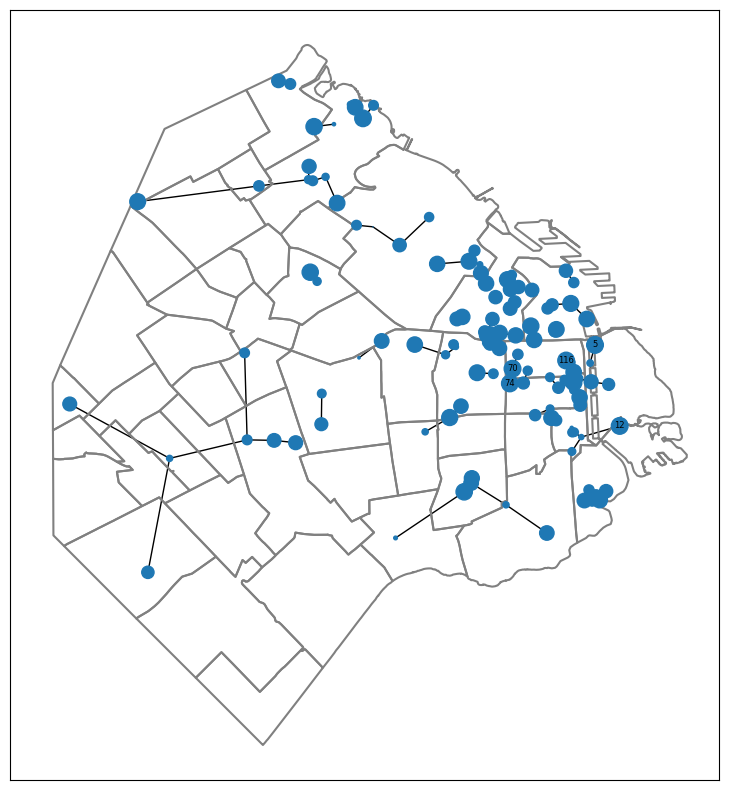

In [16]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres